In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import netCDF4
import numpy
import os
import pandas
from PIL import Image
import random
import readline
import scipy
from scipy import fft
from scipy import linalg
from scipy import stats
from scipy.stats import poisson, ttest_ind
import seaborn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_Output_V2.csv')
    ET_DF = Open_File(Diri+Model+'_ET_Output_V2.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V2.csv')
    Time = []
    Start_Time = []
    End_Time = []
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Start_Time.append(Datetime(ET_DF["Start Time"][j]))
        End_Time.append(Datetime(ET_DF["End Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Start Time"] = Start_Time
    ET_DF["End Time"] = End_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [7]:
Control_Data[280:285]

,Code,Name,Lon,Lat,SLP(hPa),Winds(m/s),B,VLT,VUT,Time(Z),Type
280,TC190105,Lydia,-59.59,28.39,921.57,64.1,-0.84,370.86,425.07,1901-09-22 18:00:00,Tropical
281,TC190105,Lydia,-60.54,28.77,920.25,64.4,-3.11,372.15,446.44,1901-09-23 00:00:00,Tropical
282,TC190105,Lydia,-60.94,28.96,919.96,65.9,-5.57,372.20,460.03,1901-09-23 06:00:00,Tropical
283,TC190105,Lydia,-61.51,29.14,917.78,65.1,-4.46,370.60,471.26,1901-09-23 12:00:00,Tropical
284,TC190105,Lydia,-61.38,29.60,916.02,67.2,-3.70,367.19,472.79,1901-09-23 18:00:00,Tropical


In [8]:
Control_ET[4:7]

,Code,Name,Path Type,Start Time,End Time,ET Duration (hr),Start SLP,End SLP,Min SLP,Start Lon,Start Lat,End Lon,End Lat,ET Distance (km),Tropical Duration (hr)
4,TC190102,Harrison,1.0,1901-05-28 12:00:00,1901-05-30 18:00:00,54.0,991.56,1008.78,980.89,-43.71,30.04,-34.75,24.00,1112.101864,132.0
5,TC190103,Jessica,1.0,1901-07-12 00:00:00,1901-07-15 06:00:00,78.0,1006.39,1013.44,1001.93,-53.11,40.34,-30.00,37.75,2004.448676,78.0
6,TC190105,Lydia,1.0,1901-09-27 12:00:00,1901-09-29 18:00:00,54.0,953.76,970.00,913.33,-53.37,39.19,-42.82,48.53,1335.846025,384.0


In [9]:
Control_Codes[4:7]

,ABC,Orig Code,New Code,Name
4,A,78,TC190102,Harrison
5,A,81,TC190103,Jessica
6,A,89,TC190105,Lydia


In [10]:
# Create Phase Distribution Bins
def Create_Bins(VT_Min, VT_Max, VT_Bin_Width, B_Min, B_Max, B_Bin_Width):
    VLT_Bins = numpy.arange(VT_Min, VT_Max+VT_Bin_Width, VT_Bin_Width)
    B_Bins = numpy.arange(B_Min, B_Max+B_Bin_Width, B_Bin_Width)
    return (VLT_Bins, B_Bins)
VLT_Bins, B_Bins = Create_Bins(-600,600,50,-45,135,7.5)
Bins_Bounds = numpy.array([-600,600,50,-45,135,7.5])
#VLT_Bins
#VLT_Bins = numpy.arange(-500,520,20)
#B_Bins = numpy.arange(-30,123,3)
#VUT_Bins = numpy.arange(-500,520,20)

In [11]:
# Create Function to Calculate Phase Space Distribution
def Phase_Space_Distribution(DF, VLT_Bins, B_Bins, Years, Type):
    VLT_B_Count = numpy.zeros((len(VLT_Bins)-1, len(B_Bins)-1))
    VLT_VUT_Count = numpy.zeros((len(VLT_Bins)-1, len(VLT_Bins)-1))
    VLT_B_Length = 0
    VLT_VUT_Length = 0
#
# Count Phase Space Distribution
    for i in range(len(DF["VLT"])):
        for j in range(len(VLT_Bins)-1):
            if DF["VLT"][i] > VLT_Bins[j] and DF["VLT"][i] <= VLT_Bins[j+1]:
                for k in range(len(B_Bins)-1):
                    if DF["B"][i] > B_Bins[k] and DF["B"][i] <= B_Bins[k+1]:
                        VLT_B_Count[j][k] += 1
                        VLT_B_Length += 1
                for l in range(len(VLT_Bins)-1):
                    if DF["VUT"][i] > VLT_Bins[l] and DF["VUT"][i] <= VLT_Bins[l+1]:
                        VLT_VUT_Count[j][l] += 1
                        VLT_VUT_Length += 1
#
# Calculate Phase Space Density
    if Type == "Annual":
        VLT_B_Density = VLT_B_Count / Years
        VLT_VUT_Density = VLT_VUT_Count / Years
    else:
        VLT_B_Density = VLT_B_Count / VLT_B_Length * 1000
        VLT_VUT_Density = VLT_VUT_Count / VLT_VUT_Length * 1000
    return (VLT_B_Density, VLT_VUT_Density)

In [12]:
# Calculate Percentage of Points in Each Quadrant
def Phase_Space_Quadrant(Density, Var, Type):
    x_Length = len(Density)
    y_Length = len(Density[0])
    x_Mid = int(x_Length / 2)
    if Type == "Relative":
        Densities = Density / 1000.
    else:
        Densities = Density
    Right_Half = Densities[x_Mid:]
    Left_Half = Densities[:x_Mid]
    Q1 = 0
    Q2 = 0
    Q3 = 0
    Q4 = 0
    if Var == "VUT":
        y_Mid = int(y_Length / 2)
    elif Var == "B":
        y_Mid = int(y_Length / 3)
    for i in range(len(Right_Half)):
        Top_Right = numpy.sum(Right_Half[i][y_Mid:])
        Q1 += Top_Right
        Bottom_Right = numpy.sum(Right_Half[i][:y_Mid])
        Q4 += Bottom_Right
    for j in range(len(Left_Half)):
        Top_Left = numpy.sum(Left_Half[j][y_Mid:])
        Q2 += Top_Left
        Bottom_Left = numpy.sum(Left_Half[j][:y_Mid])
        Q3 += Bottom_Left
    return (Q1, Q2, Q3, Q4)

In [13]:
# Create Function For Colours
Rela_Dist_Colours = ['lightskyblue', 'deepskyblue', 'dodgerblue', 'darkcyan', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
Rela_Dist_Bounds = numpy.array([0,1,2.5,5,7.5,10,15,20,25,30,40,50])
Annual_Dist_Colours = ['lightskyblue', 'deepskyblue', 'dodgerblue', 'darkcyan', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
Annual_Dist_Bounds = numpy.array([0,0.2,0.5,1,1.5,2,3,4,5,6,8,10])
# Create Function For Colours
def Dist_Colour(Density, Dist_Colours, Dist_Bounds):
    for k in range(len(Dist_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            if k != len(Dist_Colours)-1:
                if Density <= Dist_Bounds[k+1] and Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
            else:
                if Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
    return (Colour)

In [14]:
# Plot Cyclone Phase Distribution
def Cyclone_Phase_Dist_Plot(VLT_B, VLT_VUT, VLT_Bins, B_Bins, Bounds, Colours, Model, Type, Savefig):
    Fig = pyplot.figure(figsize=(16,8))
# VLT B Distribution
    Axis = Fig.add_subplot(1,2,1)
    for j in range(len(VLT_B)):
        for k in range(len(VLT_B[0])):
            Colour = Dist_Colour(VLT_B[j][k], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[3],Bins_Bounds[4]+15,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
    pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    pyplot.title(str(Model + ' Phase Space'), fontsize=15)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_B, "B", Type)
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        if Type == "Relative":
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(1,2,2)
    for j in range(len(VLT_VUT)):
        for l in range(len(VLT_VUT[0])):
            Colour = Dist_Colour(VLT_VUT[j][l], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model + ' Phase Space'), fontsize=15)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT, "VUT", Type)
    for q in range(len(Quadrant_Percent)):
        if Type == "Relative":
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    if Type == "Relative":
        Cbar_Label = 'Density (Per 1000 Data Points)'
    elif Type == "Annual":
        Cbar_Label = 'Density (Per Year)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=Cbar_Label, ticks=Bounds, shrink=0.7)
#
# Save Fig
    if Savefig == True:
        Figname = str(Model + '_Phase_Dist.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V2/'+Figname, bbox_inches='tight')

In [15]:
# Calculate Difference Between Models
def Cyclone_Phase_Diff(B_1, VUT_1, B_2, VUT_2):
    B_Diff = B_1 - B_2
    VUT_Diff = VUT_1 - VUT_2
    return (B_Diff, VUT_Diff)

In [16]:
# Create Function of Colours of Cyclone Phase Difference Plots
Rela_Diff_Colours = ['navy', 'mediumblue', 'dodgerblue', 'deepskyblue', 'turquoise', 'limegreen', 'greenyellow', \
'yellow', 'gold', 'orange', 'darkorange', 'orangered', 'red', 'firebrick']
Rela_Diff_Bounds = numpy.array([-20,-10,-6,-4,-2,-1,0,1,2,4,6,10,20])
Annual_Diff_Colours = ['navy', 'mediumblue', 'dodgerblue', 'deepskyblue', 'turquoise', 'limegreen', 'greenyellow', \
'yellow', 'gold', 'orange', 'darkorange', 'orangered', 'red', 'firebrick']
Annual_Diff_Bounds = numpy.array([-10,-5,-3,-2,-1,-0.5,0,0.5,1,2,3,5,10])
def Diff_Colour(Diff, Diff_Colours, Diff_Bounds):
    for k in range(len(Diff_Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Diff < Diff_Bounds[k]:
                    Colour = Diff_Colours[k]
            elif k < len(Diff_Colours)-1:
                if Diff <= Diff_Bounds[k] and Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
            else:
                if Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
    return (Colour)

In [17]:
# Plot Cyclone Phase Distribution Difference Between ERA and REA
def Cyclone_Phase_Diff_Plot(Model_1, Model_2, VLT_B_1, VLT_VUT_1, VLT_B_2, VLT_VUT_2, VLT_Bins, B_Bins, \
Diff_Bounds, Diff_Colours, Type, Savefig):
# Apply Difference Between Models Function
    VLT_B_Diff, VLT_VUT_Diff = Cyclone_Phase_Diff(VLT_B_1, VLT_VUT_1, VLT_B_2, VLT_VUT_2)
    Fig = pyplot.figure(figsize=(16,8))
#
# VLT B Distribution
    Axis = Fig.add_subplot(1,2,1)
    for j in range(len(VLT_B_Diff)):
        for k in range(len(VLT_B_Diff[0])):
            Colour = Diff_Colour(VLT_B_Diff[j][k], Diff_Colours, Diff_Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[3],Bins_Bounds[4]+15,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
    pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference Phase Space'), fontsize=15)
# Add Quadrant Percent
    Quadrant_Percent = numpy.array(Phase_Space_Quadrant(VLT_B_1, "B", Type)) - \
    numpy.array(Phase_Space_Quadrant(VLT_B_2, "B", Type))
    xloc = [0.85,0.15,0.15,0.85]
    yloc = [0.85,0.85,0.15,0.15]
    for q in range(len(Quadrant_Percent)):
        if Type == "Relative":
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(1,2,2)
    for j in range(len(VLT_VUT_Diff)):
        for l in range(len(VLT_VUT_Diff[0])):
            Colour = Diff_Colour(VLT_VUT_Diff[j][l], Diff_Colours, Diff_Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference Phase Space'), fontsize=15)
# Add Quadrant Percent
    Quadrant_Percent = numpy.array(Phase_Space_Quadrant(VLT_VUT_1, "VUT", Type)) - \
    numpy.array(Phase_Space_Quadrant(VLT_VUT_2, "VUT", Type))
    for q in range(len(Quadrant_Percent)):
        if Type == "Relative":
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    if Type == "Relative":
        Cbar_Label = 'Density Difference (Per 1000 Data Points)'
    elif Type == "Annual":
        Cbar_Label = 'Density Difference (Per Year)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Diff_Colours, N=len(Diff_Colours))
    Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=Cbar_Label, ticks=Diff_Bounds, shrink=0.7)
#
# Save Fig
    if Savefig == True:
        Figname = str(Model_1 + '-' + Model_2 + '_Phase_Diff.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V2/'+Figname, bbox_inches='tight')

In [18]:
# Phase Space Distribution For Control Run
Control_VLT_B_Annual, Control_VLT_VUT_Annual = Phase_Space_Distribution(Control_Data, \
VLT_Bins, B_Bins, 90, "Annual")
Control_VLT_B_Rela, Control_VLT_VUT_Rela = Phase_Space_Distribution(Control_Data, \
VLT_Bins, B_Bins, 90, "Relative")

In [19]:
# Phase Space Distribution For RCP4.5 Run
RCP45_VLT_B_Annual, RCP45_VLT_VUT_Annual = Phase_Space_Distribution(RCP45_Data, \
VLT_Bins, B_Bins, 90, "Annual")
RCP45_VLT_B_Rela, RCP45_VLT_VUT_Rela = Phase_Space_Distribution(RCP45_Data, \
VLT_Bins, B_Bins, 90, "Relative")

In [20]:
# Phase Space Distribution For RCP8.5 Run
RCP85_VLT_B_Annual, RCP85_VLT_VUT_Annual = Phase_Space_Distribution(RCP85_Data, \
VLT_Bins, B_Bins, 90, "Annual")
RCP85_VLT_B_Rela, RCP85_VLT_VUT_Rela = Phase_Space_Distribution(RCP85_Data, \
VLT_Bins, B_Bins, 90, "Relative")

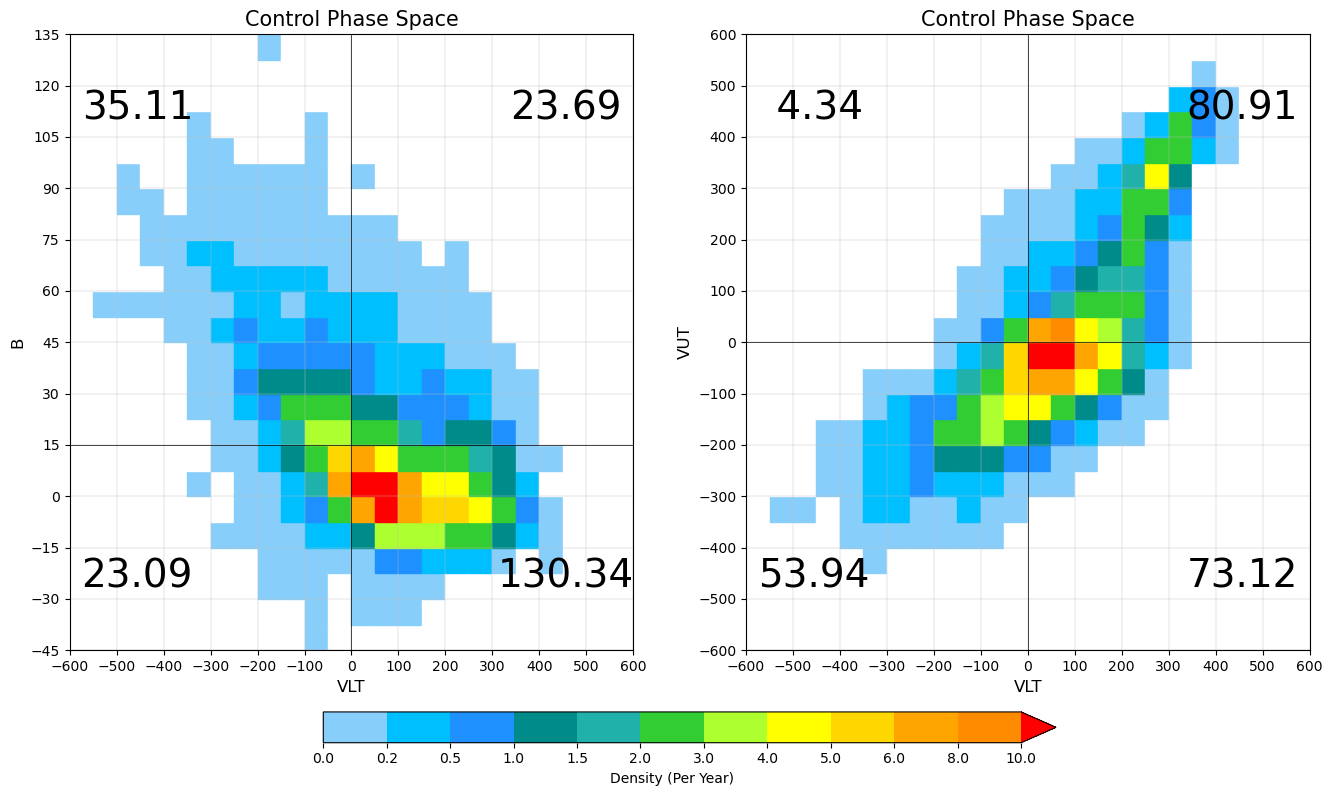

In [21]:
# Plot Phase Space Distribution For Control Run
Fig = Cyclone_Phase_Dist_Plot(Control_VLT_B_Annual, Control_VLT_VUT_Annual, VLT_Bins, B_Bins, \
Annual_Dist_Bounds, Annual_Dist_Colours, "Control", "Annual", True)

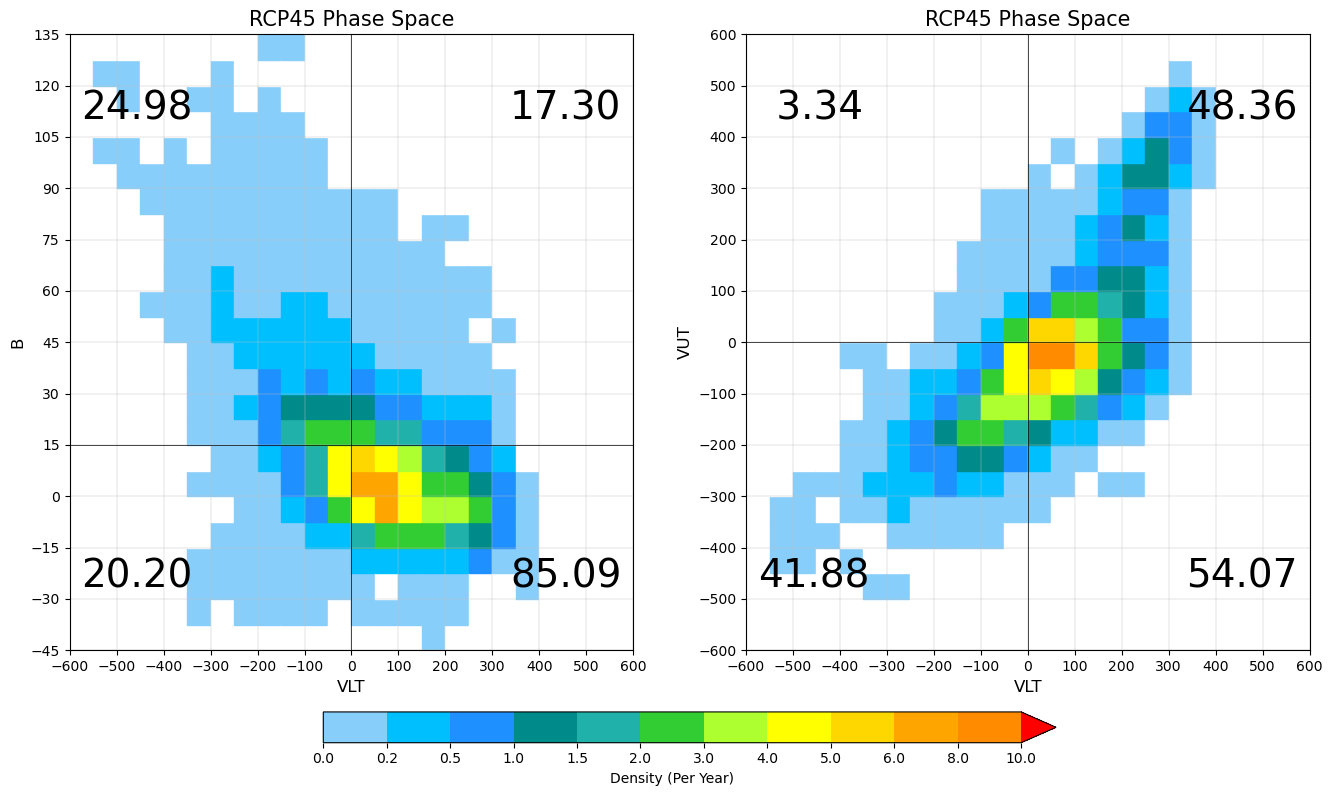

In [22]:
# Plot Phase Space Distribution For RCP4.5 Run
Fig = Cyclone_Phase_Dist_Plot(RCP45_VLT_B_Annual, RCP45_VLT_VUT_Annual, VLT_Bins, B_Bins, \
Annual_Dist_Bounds, Annual_Dist_Colours, "RCP45", "Annual", True)

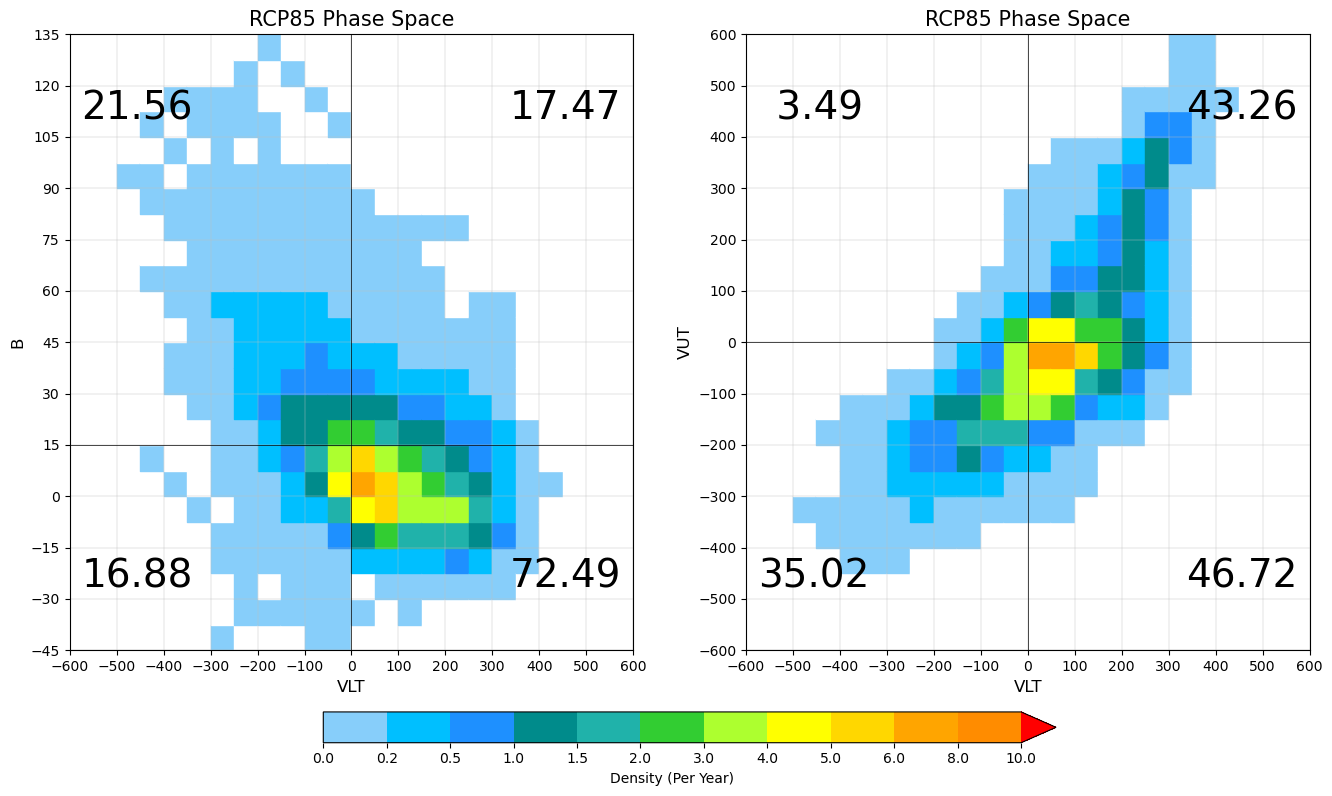

In [23]:
# Plot Phase Space Distribution For RCP8.5 Run
Fig = Cyclone_Phase_Dist_Plot(RCP85_VLT_B_Annual, RCP85_VLT_VUT_Annual, VLT_Bins, B_Bins, \
Annual_Dist_Bounds, Annual_Dist_Colours, "RCP85", "Annual", True)

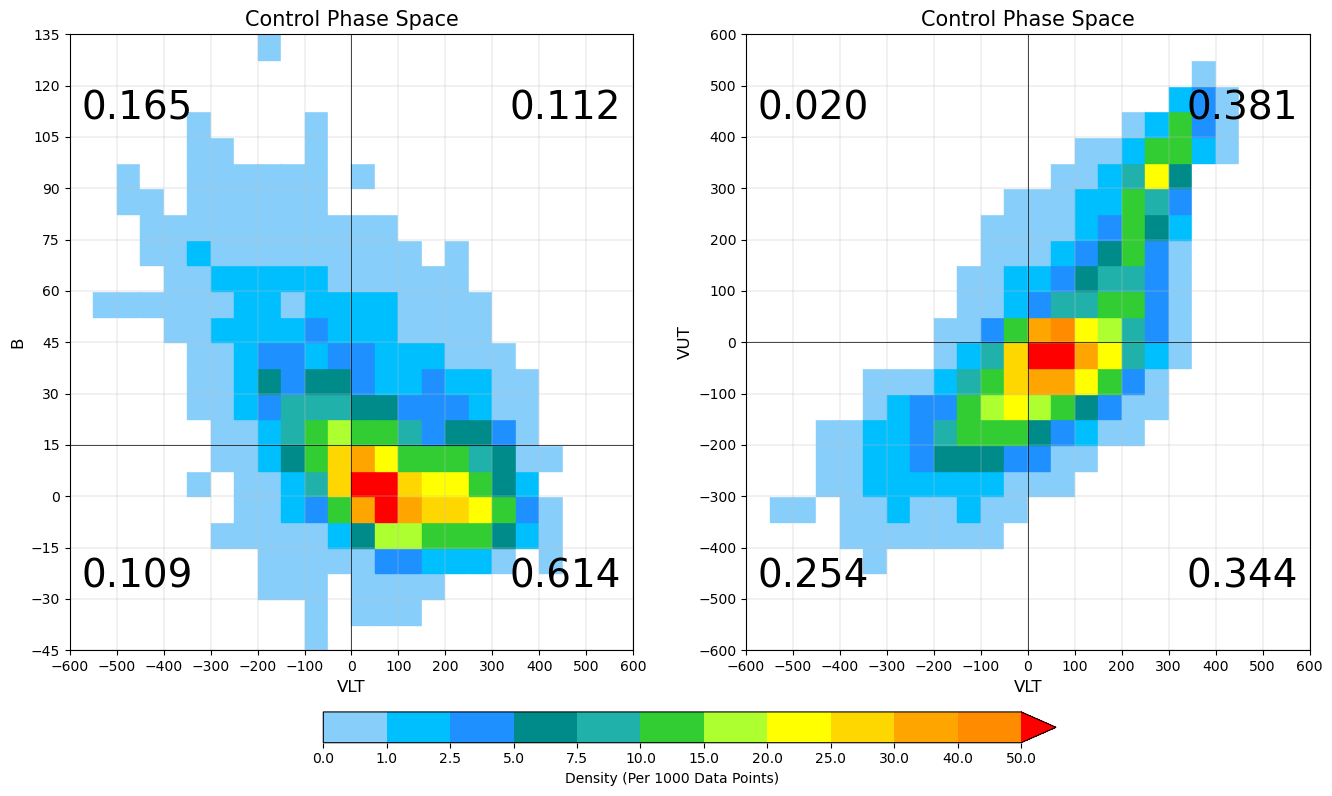

In [24]:
# Plot Phase Space Distribution For Control Run
Fig = Cyclone_Phase_Dist_Plot(Control_VLT_B_Rela, Control_VLT_VUT_Rela, VLT_Bins, B_Bins, \
Rela_Dist_Bounds, Rela_Dist_Colours, "Control", "Relative", True)

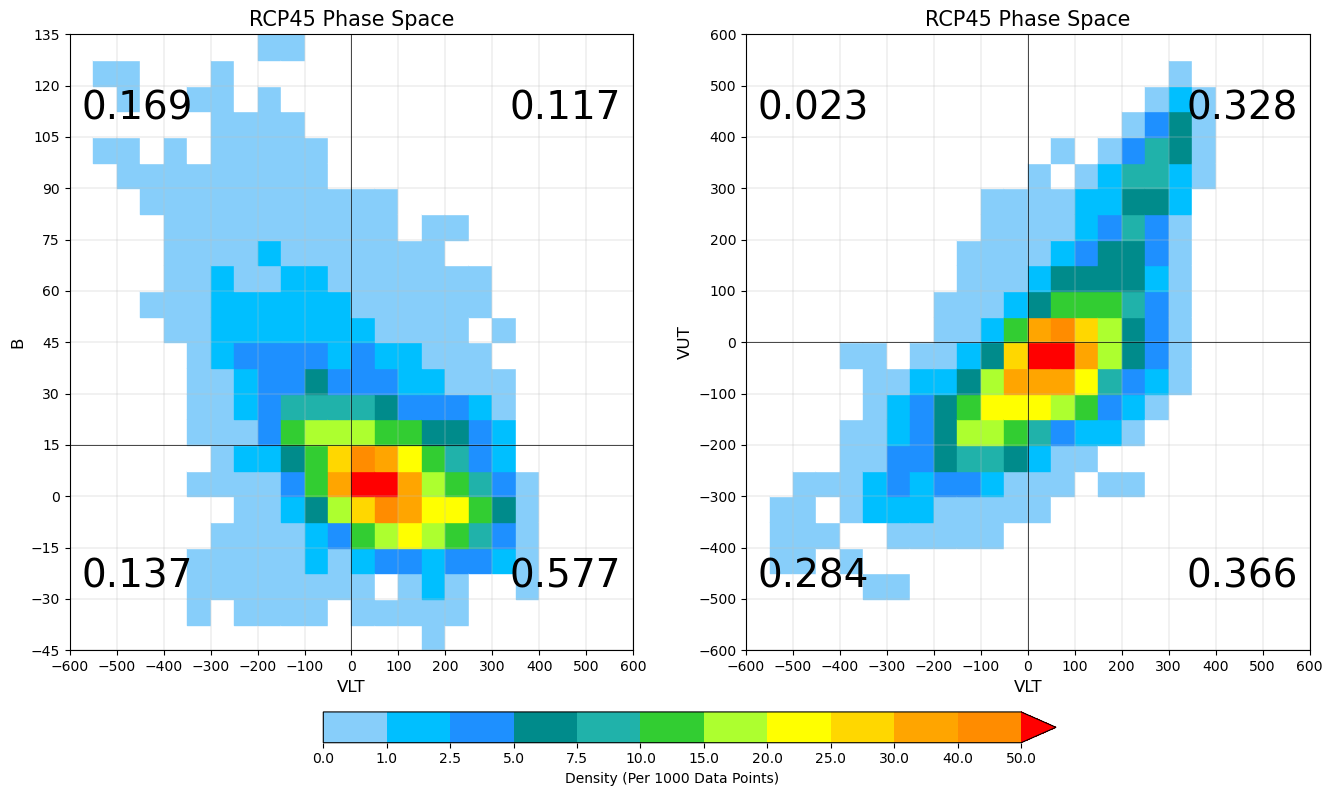

In [25]:
# Plot Phase Space Distribution For RCP4.5 Run
Fig = Cyclone_Phase_Dist_Plot(RCP45_VLT_B_Rela, RCP45_VLT_VUT_Rela, VLT_Bins, B_Bins, \
Rela_Dist_Bounds, Rela_Dist_Colours, "RCP45", "Relative", True)

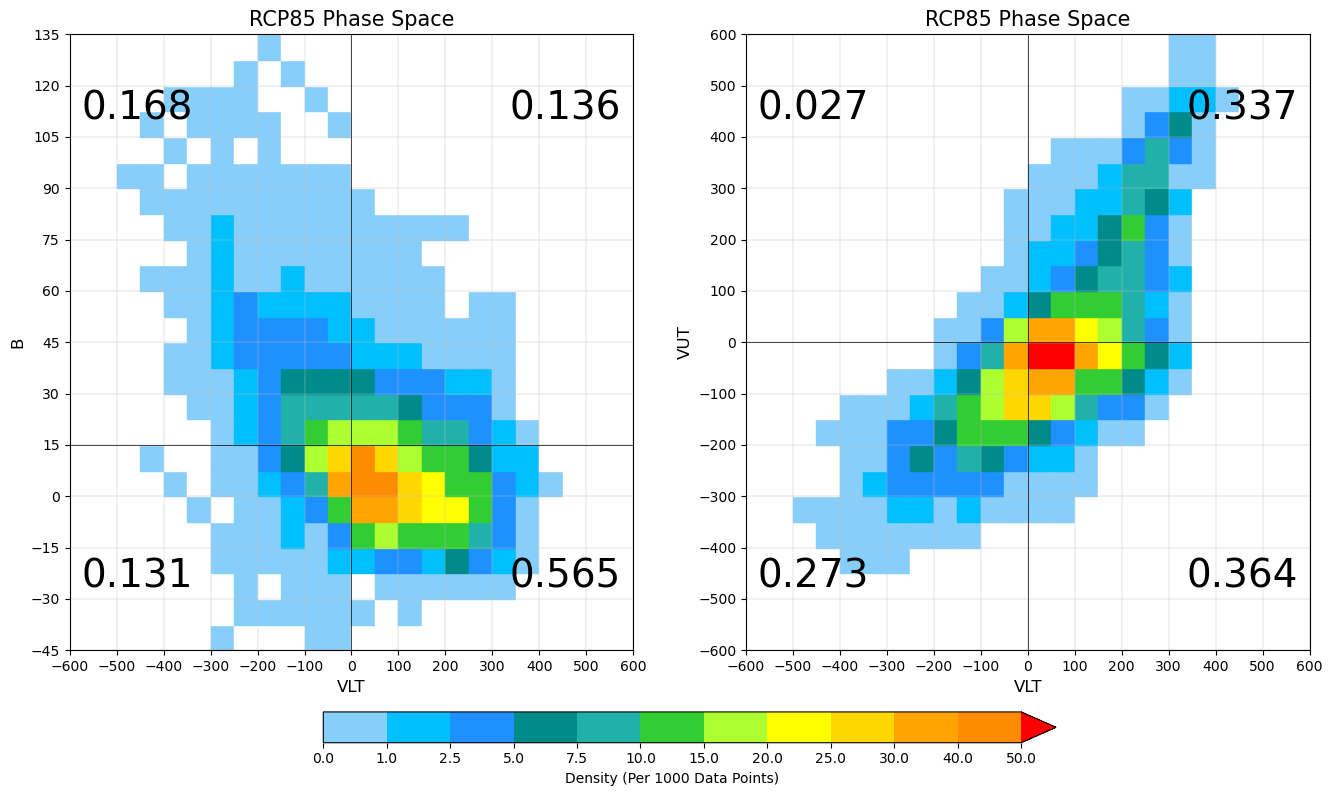

In [26]:
# Plot Phase Space Distribution For RCP8.5 Run
Fig = Cyclone_Phase_Dist_Plot(RCP85_VLT_B_Rela, RCP85_VLT_VUT_Rela, VLT_Bins, B_Bins, \
Rela_Dist_Bounds, Rela_Dist_Colours, "RCP85", "Relative", True)

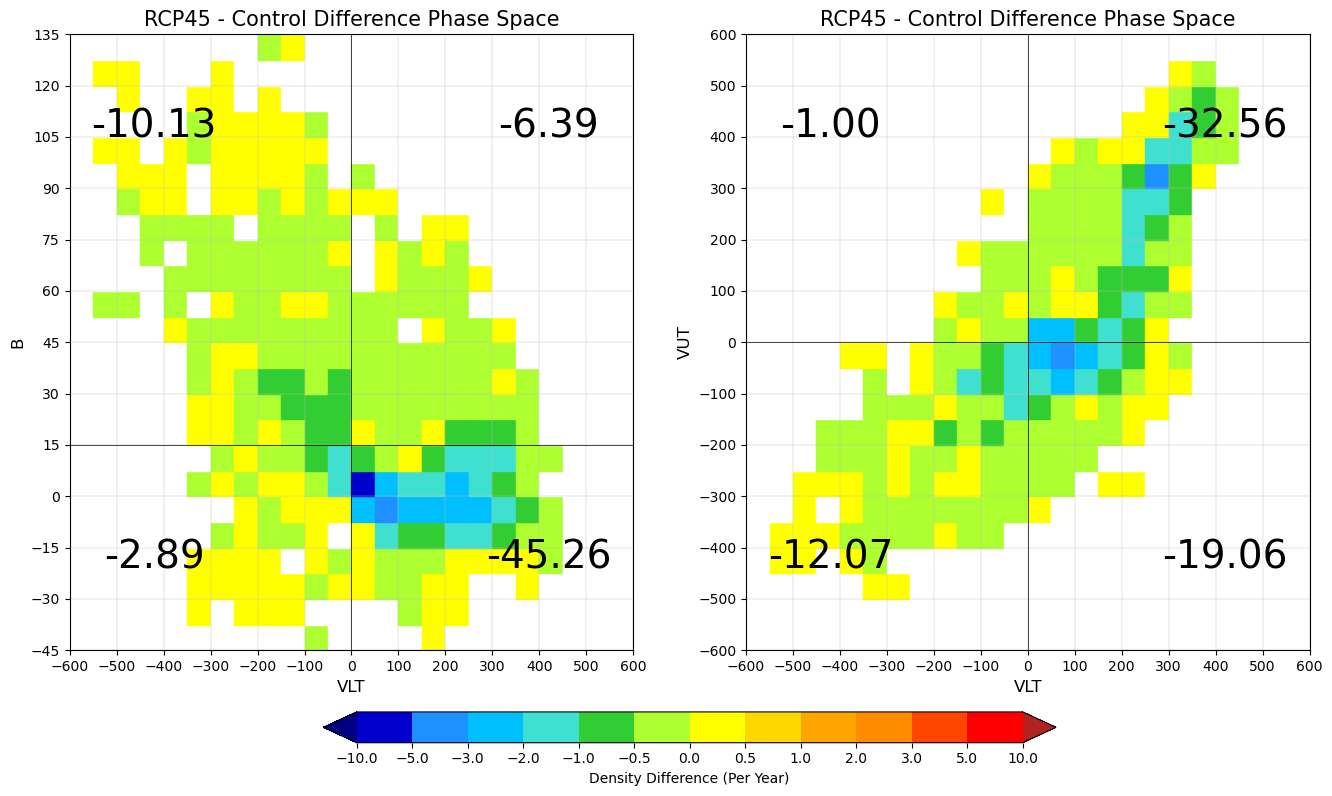

In [27]:
# Plot Difference Between Phase Space Distributions of RCP4.5 - Control
Cyclone_Phase_Diff_Plot("RCP45", "Control", RCP45_VLT_B_Annual, RCP45_VLT_VUT_Annual, Control_VLT_B_Annual, Control_VLT_VUT_Annual, \
VLT_Bins, B_Bins, Annual_Diff_Bounds, Annual_Diff_Colours, "Annual", True)

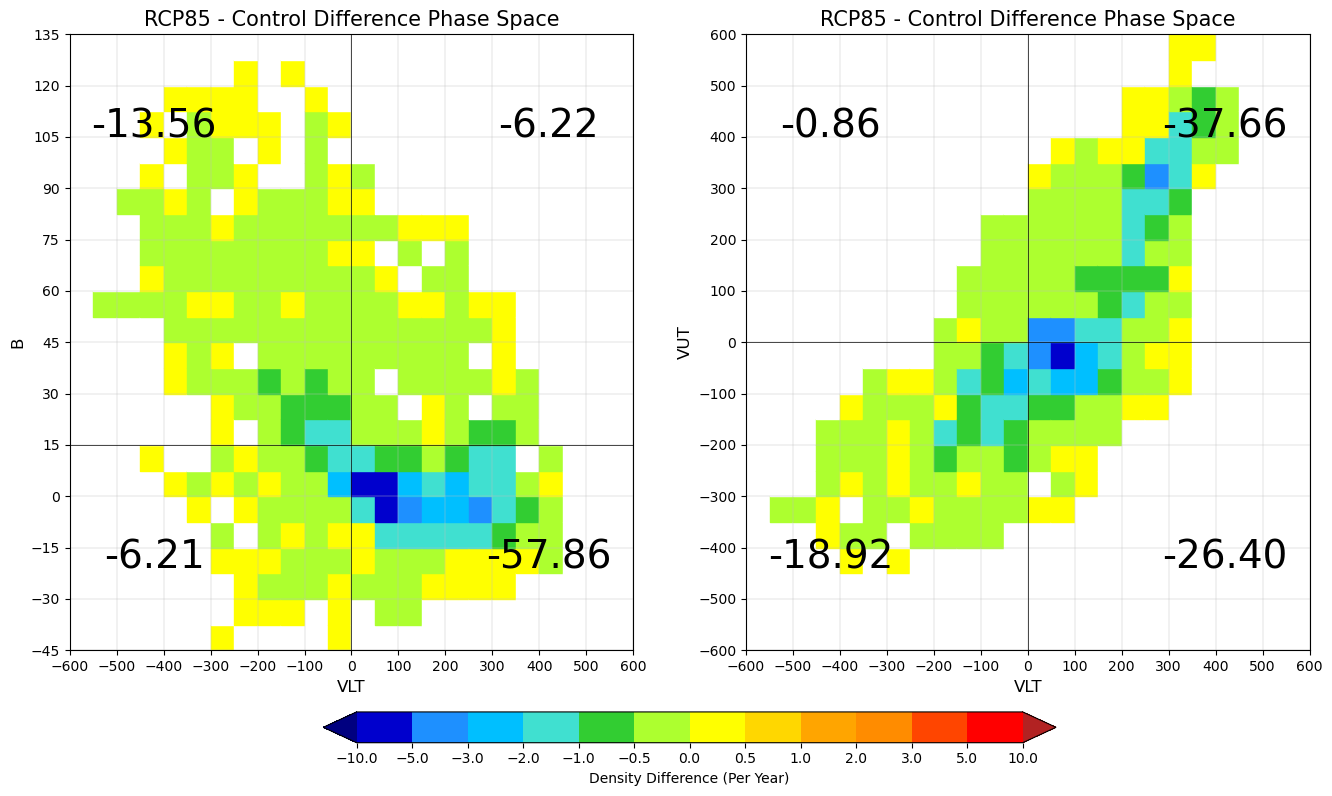

In [28]:
# Plot Difference Between Phase Space Distributions of RCP8.5 - Control
Cyclone_Phase_Diff_Plot("RCP85", "Control", RCP85_VLT_B_Annual, RCP85_VLT_VUT_Annual, Control_VLT_B_Annual, Control_VLT_VUT_Annual, \
VLT_Bins, B_Bins, Annual_Diff_Bounds, Annual_Diff_Colours, "Annual", True)

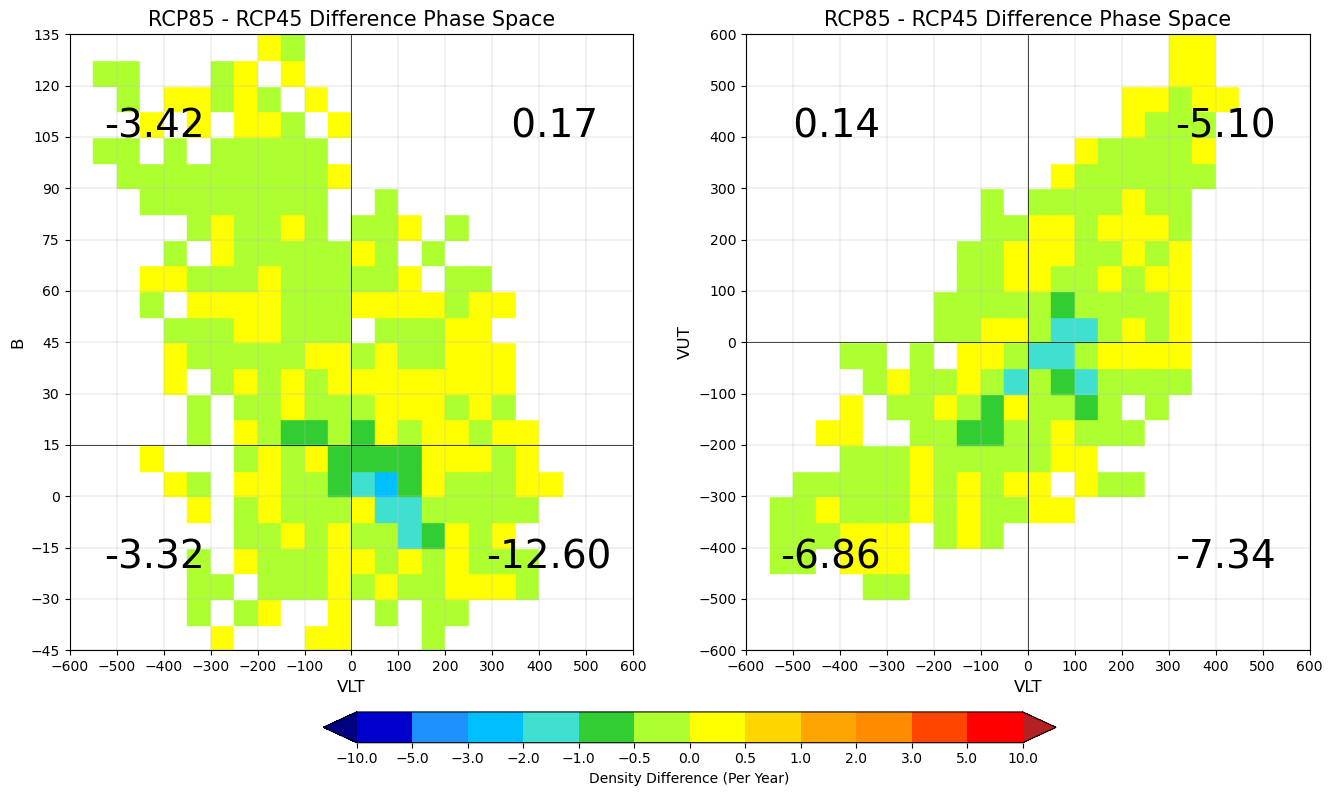

In [29]:
# Plot Difference Between Phase Space Distributions of RCP8.5 - RCP4.5
Cyclone_Phase_Diff_Plot("RCP85", "RCP45", RCP85_VLT_B_Annual, RCP85_VLT_VUT_Annual, RCP45_VLT_B_Annual, RCP45_VLT_VUT_Annual, \
VLT_Bins, B_Bins, Annual_Diff_Bounds, Annual_Diff_Colours, "Annual", True)

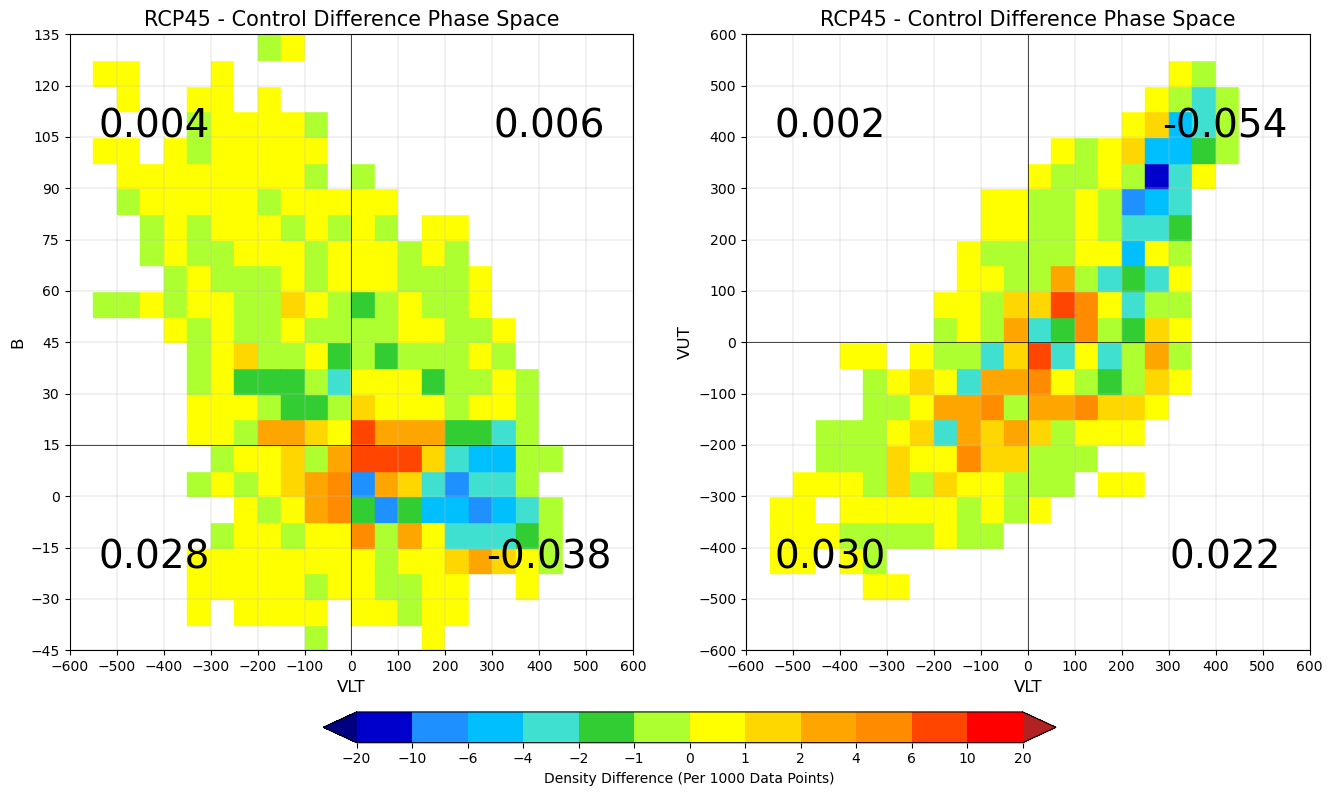

In [30]:
# Plot Difference Between Phase Space Distributions of RCP4.5 - Control
Cyclone_Phase_Diff_Plot("RCP45", "Control", RCP45_VLT_B_Rela, RCP45_VLT_VUT_Rela, Control_VLT_B_Rela, Control_VLT_VUT_Rela, \
VLT_Bins, B_Bins, Rela_Diff_Bounds, Rela_Diff_Colours, "Relative", True)

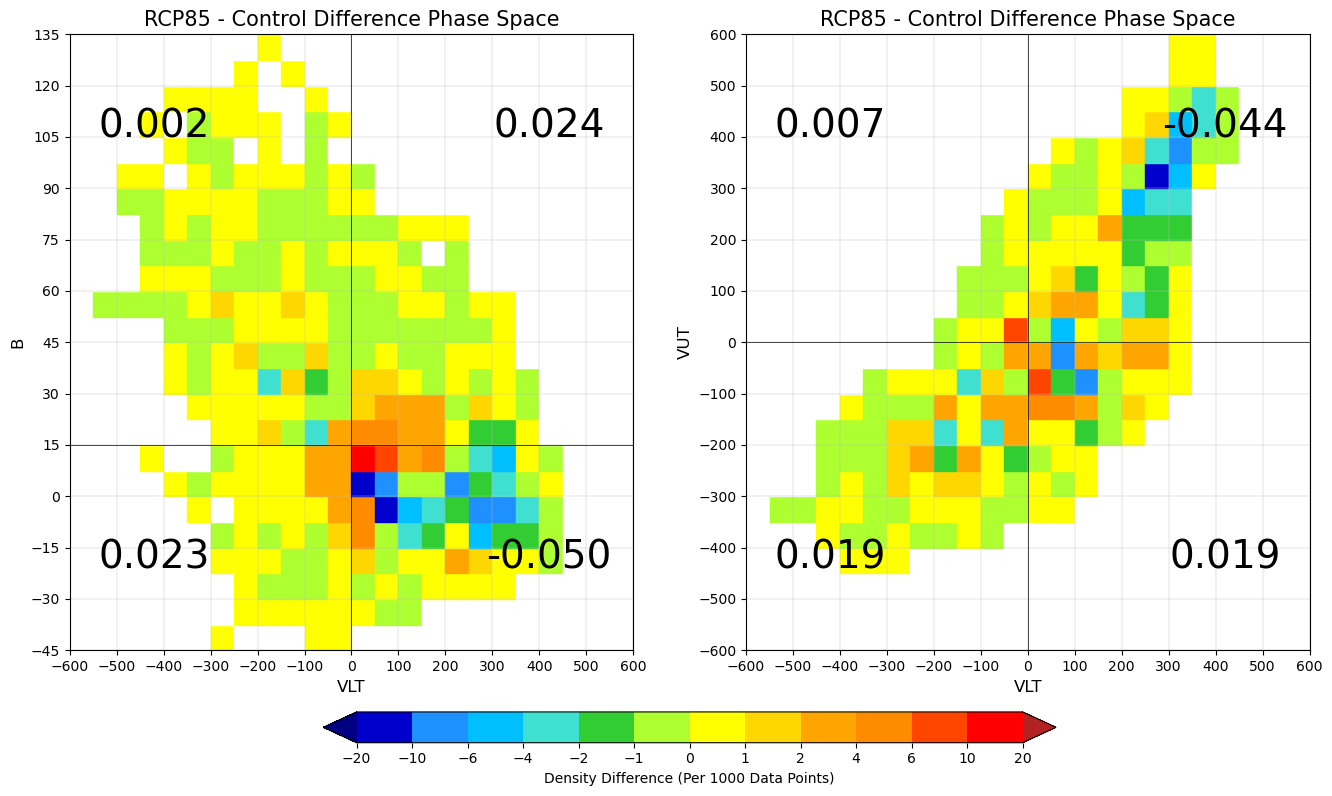

In [31]:
# Plot Difference Between Phase Space Distributions of RCP8.5 - Control
Cyclone_Phase_Diff_Plot("RCP85", "Control", RCP85_VLT_B_Rela, RCP85_VLT_VUT_Rela, Control_VLT_B_Rela, Control_VLT_VUT_Rela, \
VLT_Bins, B_Bins, Rela_Diff_Bounds, Rela_Diff_Colours, "Relative", True)

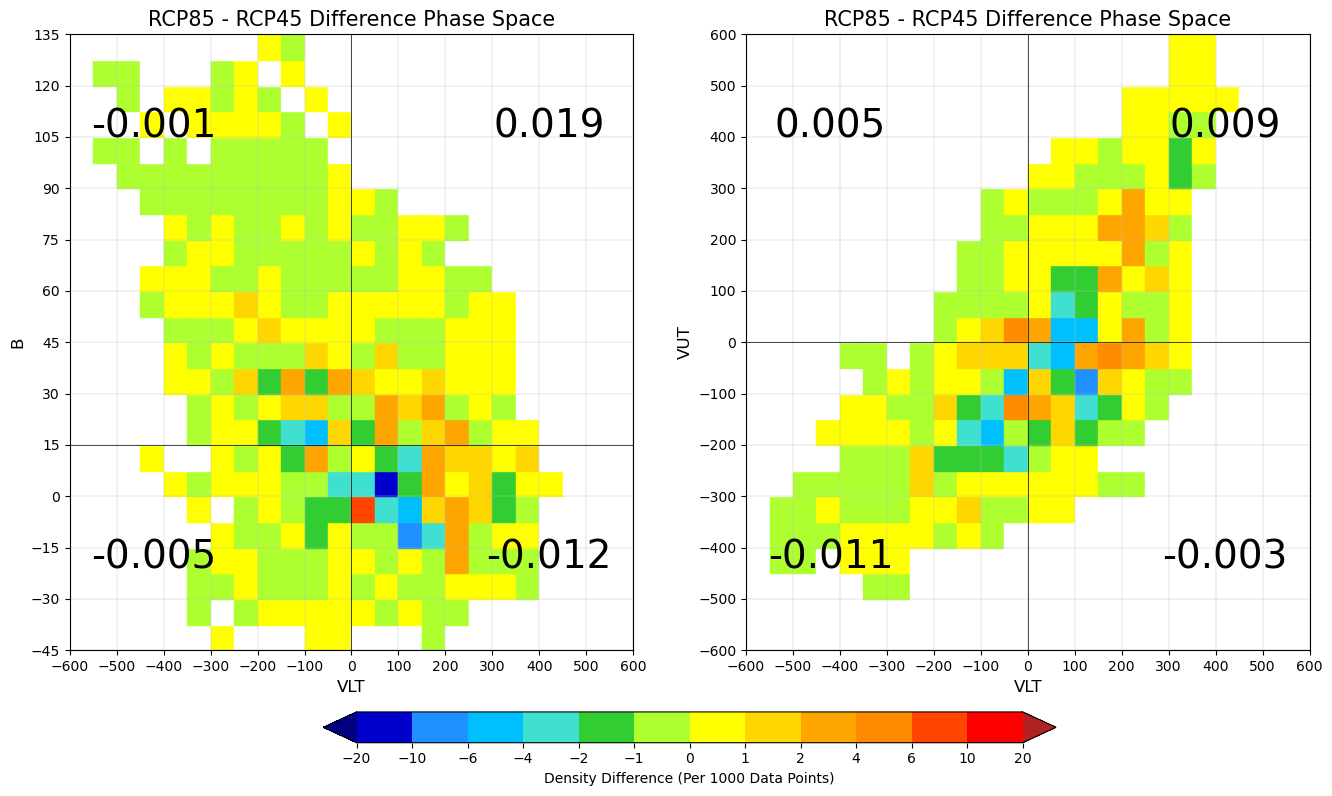

In [32]:
# Plot Difference Between Phase Space Distributions of RCP8.5 - RCP4.5
Cyclone_Phase_Diff_Plot("RCP85", "RCP45", RCP85_VLT_B_Rela, RCP85_VLT_VUT_Rela, RCP45_VLT_B_Rela, RCP45_VLT_VUT_Rela, \
VLT_Bins, B_Bins, Rela_Diff_Bounds, Rela_Diff_Colours, "Relative", True)

In [33]:
# Create Lat Bins
def Lat_Zonal_Bins(Lat_Min, Lat_Max, Lat_Bin_Width):
    Lat_Bins = numpy.arange(Lat_Min, Lat_Max+Lat_Bin_Width, Lat_Bin_Width)
    return (Lat_Bins)
#Lat_Bins, Lon_Bins = Lat_Lon_Bins(0,65,5,-105,15,5)
#print (Lat_Bins)
#print (Lon_Bins)

In [34]:
# Create Function to Calculate Spatial Distribution of B Value
def Zonal_Distribution(DF, Var, Lat_Bins):
    Lat_Count = numpy.zeros(len(Lat_Bins)-1)
    Lat_Values_Sum = numpy.zeros(len(Lat_Bins)-1)
    Lat_Values_Mean = numpy.zeros(len(Lat_Bins)-1)
#
# Create Boundaries For Values to Ignore NaN and Ignore WeakStorms With SLP > 1010hPa
    if Var == "VLT" or Var == "VUT":
        Value_Bounds = numpy.array([Bins_Bounds[0],Bins_Bounds[1]])
    if Var == "B":
        Value_Bounds = numpy.array([Bins_Bounds[3],Bins_Bounds[4]])
    SLP_Bounds = 1010
#
# Count Lat Lon Distribution and Sum of Values in Each Gridbox
    for i in range(len(DF[Var])):
        if DF["SLP(hPa)"][i] <= SLP_Bounds:
            if DF[Var][i] >= Value_Bounds[0] and DF[Var][i] <= Value_Bounds[1]:
                for j in range(len(Lat_Bins)-1):
                    if DF["Lat"][i] > Lat_Bins[j] and DF["Lat"][i] <= Lat_Bins[j+1]:
                        Lat_Count[j] += 1
                        Lat_Values_Sum[j] += DF[Var][i]
#
# Calculate Average Value in Each Gridbox
    for j in range(len(Lat_Count)):
# Ignore Gridboxes with <= 10 Values
        if Lat_Count[j] > 10:
                Lat_Values_Mean[j] = Lat_Values_Sum[j] / Lat_Count[j]
    return (Lat_Values_Mean)

In [35]:
def Trans_Lat_Find(Lat_Values, Lat_Bins, Var):
    Trans_Lat = 728
    if Var == "B":
        Trans_Value = 15
        for j in range(len(Lat_Values)):
#            print (Lat_Values[j], Lat_Bins[j])
            if Lat_Values[j] > Trans_Value and Lat_Bins[j] < Trans_Lat and Lat_Bins[j] > 30:
                Trans_Lat = Lat_Bins[j]
    else:
        Trans_Value = 0
        for j in range(len(Lat_Values)):
#            print (Lat_Values[j], Lat_Bins[j])
            if Lat_Values[j] < Trans_Value and Lat_Bins[j] < Trans_Lat and Lat_Bins[j] > 30:
                Trans_Lat = Lat_Bins[j]
    return (Trans_Lat)

In [36]:
# Plot Zonal Distributions
def Zonal_Plots(Zonal_B, Zonal_VLT, Zonal_VUT, Lat_Bins, B_Bounds, B_Colours, VT_Bounds, VT_Colours, \
Model, Trans_Line, Savefig):
# Add Coastlines
    Fig = pyplot.figure(figsize=(8,12))
    Axis = Fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
    Plot_Formatting(Fig, Axis)
    pyplot.title(str(Model + ' Zonal Distribution of B'), fontsize=18)
# Zonal Distribution of B
    for j in range(len(Zonal_B)):
        Colour = Plot_Colour(Zonal_B[j], B_Bounds, B_Colours)
        pyplot.fill_between([-105,30], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
# Plot Transition Latitude
    if Trans_Line == True:
        Trans_Lat = Trans_Lat_Find(Zonal_B, Lat_Bins, "B")
        pyplot.plot([-105,30], [Trans_Lat, Trans_Lat], color='black', linestyle='--', linewidth=2.8)
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("", B_Colours, N=len(B_Colours))
    Norm = mcolors.BoundaryNorm(B_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([1.020, 0.018, 0.030, 0.950], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='vertical', cax=Cax, ticks=B_Bounds)
#
# Zonal Distribution of VLT
    Axis = Fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
    Plot_Formatting(Fig, Axis)
    pyplot.title(str(Model + ' Zonal Distribution of VLT'), fontsize=18)
    for j in range(len(Zonal_VLT)):
        Colour = Plot_Colour(Zonal_VLT[j], VT_Bounds, VT_Colours)
        pyplot.fill_between([-105,30], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
# Plot Transition Latitude
    if Trans_Line == True:
        Trans_Lat = Trans_Lat_Find(Zonal_VLT, Lat_Bins, "VLT")
        pyplot.plot([-105,30], [Trans_Lat, Trans_Lat], color='black', linestyle='--', linewidth=2.8)
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("", VT_Colours, N=len(VT_Colours))
    Norm = mcolors.BoundaryNorm(VT_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([1.020, 0.018, 0.030, 0.950], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='vertical', cax=Cax, ticks=VT_Bounds)
#
# Zonal Distribution of VUT
    Axis = Fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
    Plot_Formatting(Fig, Axis)
    pyplot.title(str(Model + ' Zonal Distribution of VUT'), fontsize=18)
    for j in range(len(Zonal_VUT)):
        Colour = Plot_Colour(Zonal_VUT[j], VT_Bounds, VT_Colours)
        pyplot.fill_between([-105,30], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
# Plot Transition Latitude
    if Trans_Line == True:
        Trans_Lat = Trans_Lat_Find(Zonal_VUT, Lat_Bins, "VUT")
        pyplot.plot([-105,30], [Trans_Lat, Trans_Lat], color='black', linestyle='--', linewidth=2.8)
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("", VT_Colours, N=len(VT_Colours))
    Norm = mcolors.BoundaryNorm(VT_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([1.020, 0.018, 0.030, 0.950], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='vertical', cax=Cax, ticks=VT_Bounds)
#
# Save Fig
    if Savefig == True:
        Figname = str(Model + '_Zonal_Plots.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V2/'+Figname, bbox_inches='tight')

In [53]:
# Calculate Difference Between Models
def Spatial_Diff(Val_1, Val_2):
    if Val_1 != 0 and Val_2 != 0:
        Diff = Val_1 - Val_2
    else:
        Diff = 0
    return (Diff)

In [59]:
# Plot Zonal Distributions
def Zonal_Diff_Plot(Model_1, Model_2, B_1, B_2, VLT_1, VLT_2, VUT_1, VUT_2, Lat_Bins, \
B_Diff_Bounds, B_Diff_Colours, VT_Diff_Bounds, VT_Diff_Colours, Savefig):
# Apply Difference Between Models Function
    B_Diff = numpy.zeros(len(B_1))
    VLT_Diff = numpy.zeros(len(VLT_1))
    VUT_Diff = numpy.zeros(len(VUT_1))
    for j in range(len(B_1)):
        B_Diff[j] = Spatial_Diff(B_1[j], B_2[j])
        VLT_Diff[j] = Spatial_Diff(VLT_1[j], VLT_2[j])
        VUT_Diff[j] = Spatial_Diff(VUT_1[j], VUT_2[j])
#
# Add Coastlines
    Fig = pyplot.figure(figsize=(8,12))
    Axis = Fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
    Plot_Formatting(Fig, Axis)
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference in B'), fontsize=18)
# Zonal Distribution of B
    for j in range(len(B_Diff)):
        Colour = Diff_Colour(B_Diff[j], B_Diff_Bounds, B_Diff_Colours)
        pyplot.fill_between([-105,30], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("", B_Diff_Colours, N=len(B_Diff_Colours))
    Norm = mcolors.BoundaryNorm(B_Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([1.020, 0.018, 0.030, 0.950], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='vertical', cax=Cax, ticks=B_Diff_Bounds)
#
# Zonal Distribution of VLT
    Axis = Fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
    Plot_Formatting(Fig, Axis)
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference in VLT'), fontsize=18)
    for j in range(len(VLT_Diff)):
        Colour = Diff_Colour(VLT_Diff[j], VT_Diff_Bounds, VT_Diff_Colours)
        pyplot.fill_between([-105,30], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("", VT_Diff_Colours, N=len(VT_Diff_Colours))
    Norm = mcolors.BoundaryNorm(VT_Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([1.020, 0.018, 0.030, 0.950], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='vertical', cax=Cax, ticks=VT_Diff_Bounds)
#
# Zonal Distribution of VUT
    Axis = Fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
    Plot_Formatting(Fig, Axis)
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference in VUT'), fontsize=18)
    for j in range(len(VUT_Diff)):
        Colour = Diff_Colour(VUT_Diff[j], VT_Diff_Bounds, VT_Diff_Colours)
        pyplot.fill_between([-105,30], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("", VT_Diff_Colours, N=len(VT_Diff_Colours))
    Norm = mcolors.BoundaryNorm(VT_Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([1.020, 0.018, 0.030, 0.950], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='vertical', cax=Cax, ticks=VT_Diff_Bounds)
#
# Save Fig
    if Savefig == True:
        Figname = str(Model_1 + '-' + Model_2 + '_Zonal_Diff.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V2/'+Figname, bbox_inches='tight')

In [37]:
def Plot_Formatting(Fig, Axis):
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    x_Axis = numpy.arange(-105,30,15)
    y_Axis = numpy.arange(0,75,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-105,5)
    pyplot.ylim(0,65)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [38]:
# Create Function For B Value Colours
B_Colours = ['red', 'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'limegreen', 'turquoise', 'deepskyblue', 'dodgerblue', 'mediumblue']
B_Bounds = numpy.array([-5,0,5,10,15,20,25,30,35,40])
VLT_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
VLT_Bounds = numpy.array([-150,-100,-50,-25,0,25,50,100,150])
def Plot_Colour(Value, Bounds, Colours):
    for k in range(len(Colours)):
        if Value == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Value <= Bounds[k]:
                    Colour = Colours[k]
            if k != len(Colours)-1:
                if Value <= Bounds[k] and Value > Bounds[k-1]:
                    Colour = Colours[k]
            else:
                if Value > Bounds[k-1]:
                    Colour = Colours[k]
    return (Colour)

In [51]:
# Create Function of Colours of Spatial Distribution Difference Plots
B_Diff_Colours = ['red', 'orangered', 'darkorange', 'orange', 'gold', \
'cyan', 'deepskyblue', 'dodgerblue', 'mediumblue', 'navy']
B_Diff_Bounds = numpy.array([-10,-7.5,-5,-2.5,0,2.5,5,7.5,10])
VT_Diff_Colours = ['navy', 'mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', \
'gold', 'orange', 'darkorange', 'orangered', 'red']
VT_Diff_Bounds = numpy.array([-100,-75,-50,-25,0,25,50,75,100])
def Diff_Colour(Diff, Diff_Bounds, Diff_Colours):
    for k in range(len(Diff_Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Diff < Diff_Bounds[k]:
                    Colour = Diff_Colours[k]
            elif k < len(Diff_Colours)-1:
                if Diff <= Diff_Bounds[k] and Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
            else:
                if Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
    return (Colour)

In [39]:
Lat_Bins_5 = Lat_Zonal_Bins(0,70,5)

In [40]:
Control_Zonal_B = Zonal_Distribution(Control_Data, "B", Lat_Bins_5)
Control_Zonal_VLT = Zonal_Distribution(Control_Data, "VLT", Lat_Bins_5)
Control_Zonal_VUT = Zonal_Distribution(Control_Data, "VUT", Lat_Bins_5)

In [41]:
RCP45_Zonal_B = Zonal_Distribution(RCP45_Data, "B", Lat_Bins_5)
RCP45_Zonal_VLT = Zonal_Distribution(RCP45_Data, "VLT", Lat_Bins_5)
RCP45_Zonal_VUT = Zonal_Distribution(RCP45_Data, "VUT", Lat_Bins_5)

In [42]:
RCP85_Zonal_B = Zonal_Distribution(RCP85_Data, "B", Lat_Bins_5)
RCP85_Zonal_VLT = Zonal_Distribution(RCP85_Data, "VLT", Lat_Bins_5)
RCP85_Zonal_VUT = Zonal_Distribution(RCP85_Data, "VUT", Lat_Bins_5)

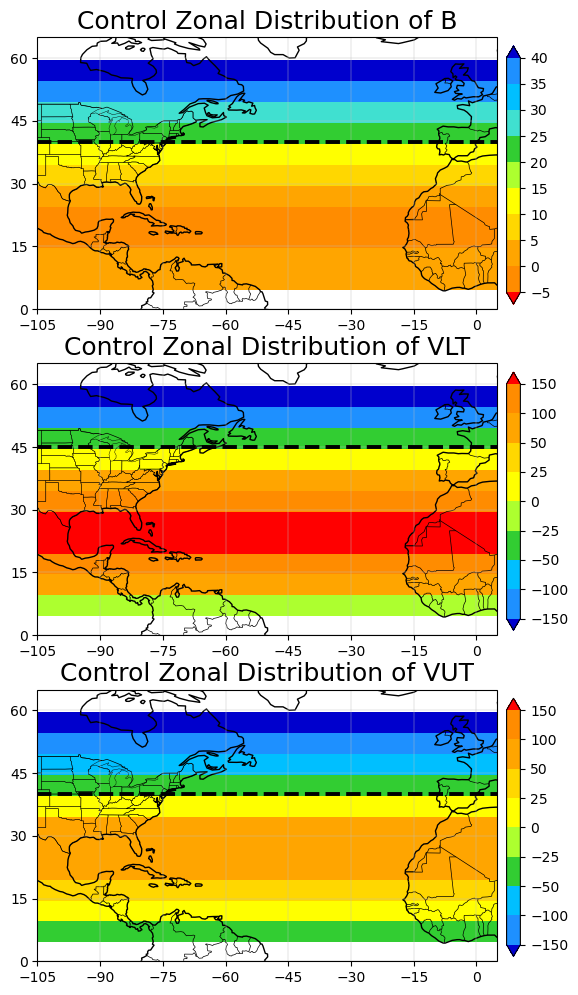

In [43]:
Zonal_Plots(Control_Zonal_B, Control_Zonal_VLT, Control_Zonal_VUT, Lat_Bins_5, \
B_Bounds, B_Colours, VLT_Bounds, VLT_Colours, "Control", True, True)

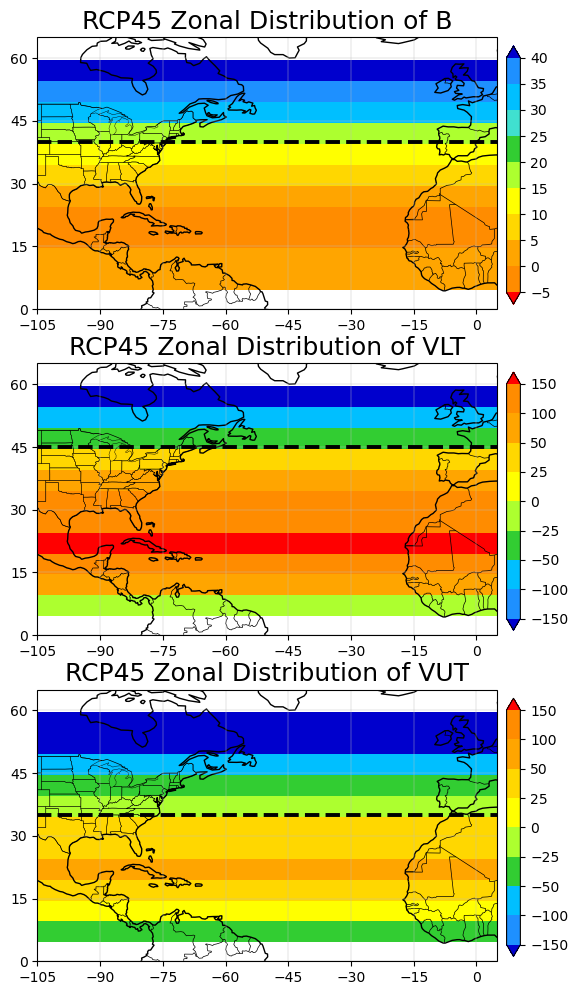

In [44]:
Zonal_Plots(RCP45_Zonal_B, RCP45_Zonal_VLT, RCP45_Zonal_VUT, Lat_Bins_5, \
B_Bounds, B_Colours, VLT_Bounds, VLT_Colours, "RCP45", True, True)

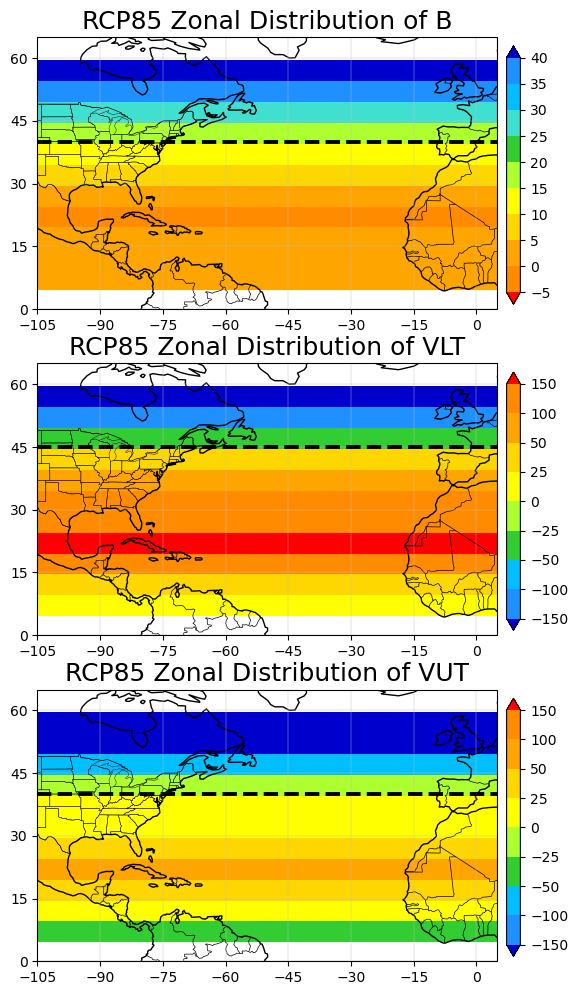

In [45]:
Zonal_Plots(RCP85_Zonal_B, RCP85_Zonal_VLT, RCP85_Zonal_VUT, Lat_Bins_5, \
B_Bounds, B_Colours, VLT_Bounds, VLT_Colours, "RCP85", True, True)

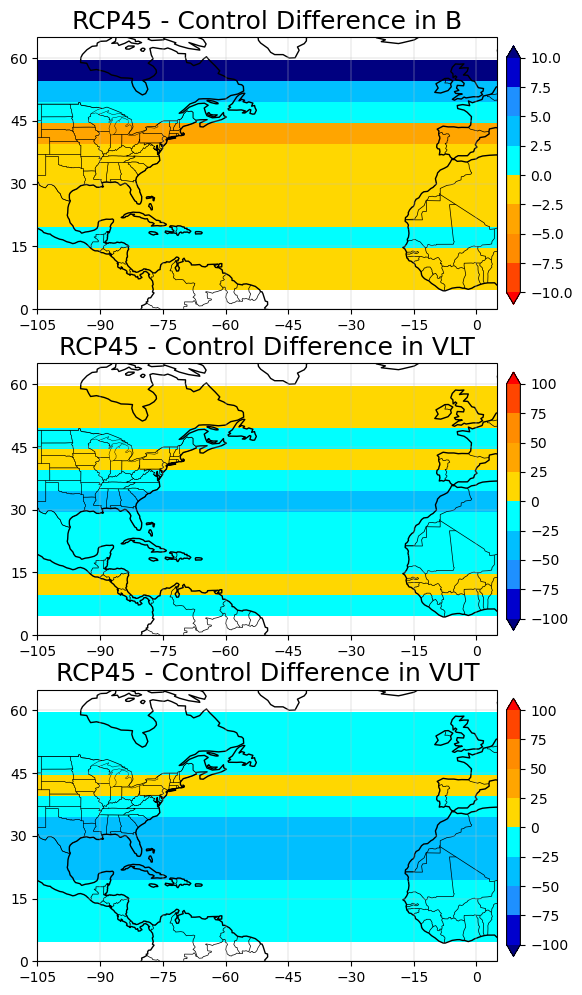

In [60]:
# Plot Difference in Zonal Distribution of RCP45 - Control
Fig = Zonal_Diff_Plot("RCP45", "Control", RCP45_Zonal_B, Control_Zonal_B, \
RCP45_Zonal_VLT, Control_Zonal_VLT, RCP45_Zonal_VUT, Control_Zonal_VUT, \
Lat_Bins_5, B_Diff_Bounds, B_Diff_Colours, VT_Diff_Bounds, VT_Diff_Colours, True)

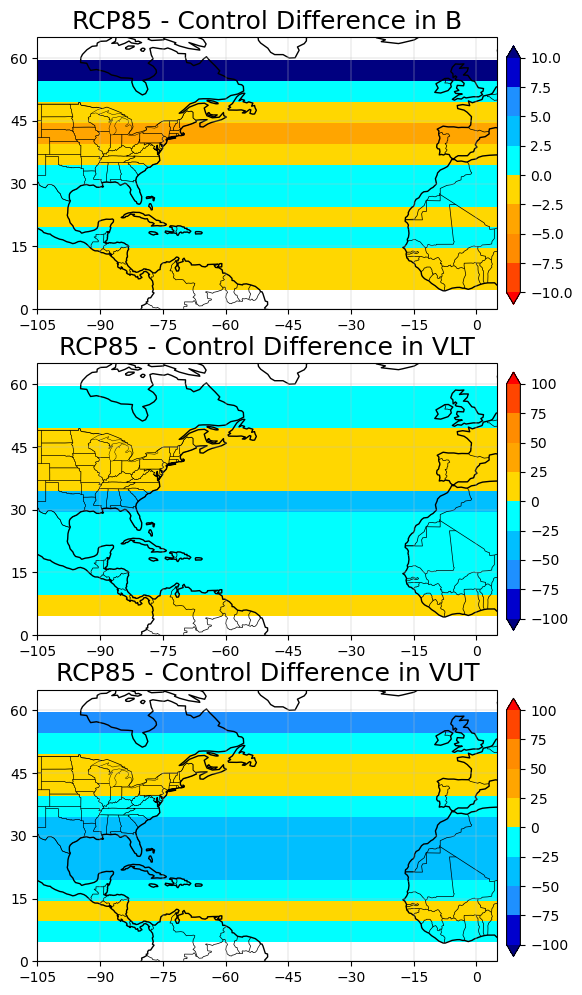

In [61]:
# Plot Difference in Zonal Distribution of RCP85 - Control
Fig = Zonal_Diff_Plot("RCP85", "Control", RCP85_Zonal_B, Control_Zonal_B, \
RCP85_Zonal_VLT, Control_Zonal_VLT, RCP85_Zonal_VUT, Control_Zonal_VUT, \
Lat_Bins_5, B_Diff_Bounds, B_Diff_Colours, VT_Diff_Bounds, VT_Diff_Colours, True)

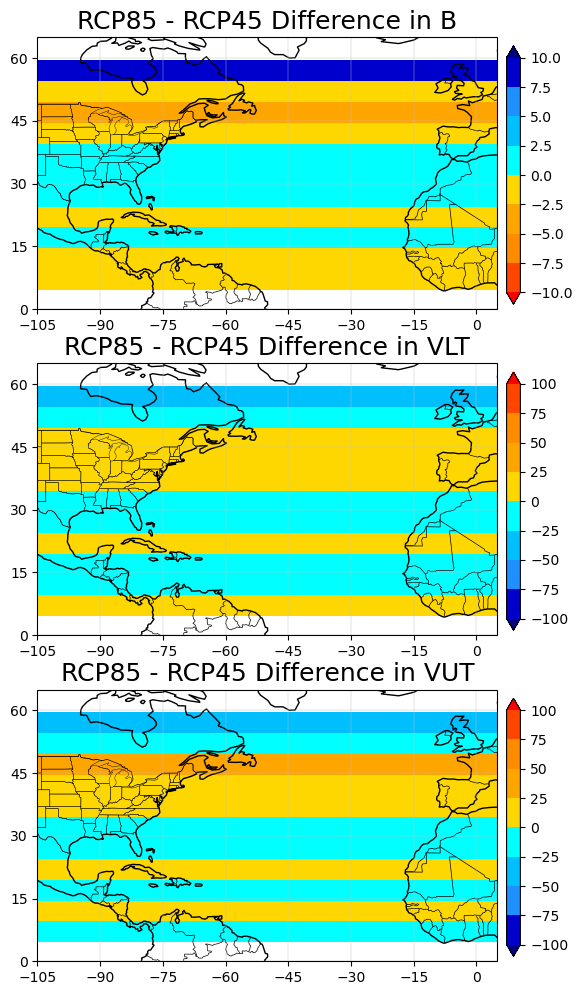

In [62]:
# Plot Difference in Zonal Distribution of RCP85 - RCP45
Fig = Zonal_Diff_Plot("RCP85", "RCP45", RCP85_Zonal_B, RCP45_Zonal_B, \
RCP85_Zonal_VLT, RCP45_Zonal_VLT, RCP85_Zonal_VUT, RCP45_Zonal_VUT, \
Lat_Bins_5, B_Diff_Bounds, B_Diff_Colours, VT_Diff_Bounds, VT_Diff_Colours, True)

In [63]:
# Function to Plot Cumulative Distribution Functions
def Cum_Dist(Array, Direction):
    Array_1 = Array[Array > -728]
    if Direction == "Up":
        Sorted = numpy.sort(Array_1)
    else:
        Sorted = numpy.sort(Array_1)[::-1]
    Len = len(Sorted)
    Density = numpy.arange(0,1.0001,1/(Len-1))
    return (Sorted, Density)

In [64]:
# Function to Plot Cumulative Distribution Functions
def Cum_Dist_Date(Array):
    Days_Array = numpy.zeros(len(Array))
    for i in range(len(Array)):
        Time = Array[i].date()
        Year = Time.year
        NYD = datetime.date(Year,1,1)
        Days = Time - NYD
        Days_Array[i] = Days.days
    Sorted = numpy.sort(Days_Array)
    Len = len(Sorted)
    Density = numpy.arange(0,1.0001,1/(Len-1))
    return (Sorted, Density)

In [65]:
Month_Days = numpy.zeros(13)
for m in range(13):
    if m < 12:
        Days = datetime.date(2023,m+1,1) - datetime.date(2023,1,1)
        Month_Days[m] = int(Days.days)
    else:
        Month_Days[m] = 365
Month_Days
Months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan"]

In [118]:
# Create Function to Plot ET Cumulative Distributions
def ET_Cum_Dist_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var):
    if Var == "Start Lat" or Var == "Start Lon" or Var == "Start SLP" or Var == "ET Duration (hr)" or \
    Var == "Tropical Duration (hr)":
        Axis = Fig.add_subplot(1,2,1)
    elif Var == "End Lat" or Var == "End Lon" or Var == "End SLP" or Var == "ET Distance (km)" or Var == "Start Time":
        Axis = Fig.add_subplot(1,2,2)
#
# Apply Cumulative Distribution Function
    if Var == "Start Lat" or Var == "End Lat" or Var == "ET Duration (hr)" or Var == "ET Distance (km)" or \
    Var == "Tropical Duration (hr)":
        Sorted_1, Density_1 = Cum_Dist(ET_DF_1[Var], "Up")
        Sorted_2, Density_2 = Cum_Dist(ET_DF_2[Var], "Up")
        Sorted_3, Density_3 = Cum_Dist(ET_DF_3[Var], "Up")
    elif Var == "Start Lon" or Var == "End Lon" or Var == "Start SLP" or Var == "End SLP":
        Sorted_1, Density_1 = Cum_Dist(ET_DF_1[Var], "Down")
        Sorted_2, Density_2 = Cum_Dist(ET_DF_2[Var], "Down")
        Sorted_3, Density_3 = Cum_Dist(ET_DF_3[Var], "Down")
    elif Var == "Start Time":
        Sorted_1, Density_1 = Cum_Dist_Date(ET_DF_1[Var])
        Sorted_2, Density_2 = Cum_Dist_Date(ET_DF_2[Var])
        Sorted_3, Density_3 = Cum_Dist_Date(ET_DF_3[Var])
        
#
# Plotting
    if Var == "Start Lat" or Var == "End Lat":
        Axis.plot(Density_1, Sorted_1, color='limegreen', linestyle='-', linewidth=5.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Sorted_2, color='orange', linestyle='--', linewidth=5.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Sorted_3, color='red', linestyle=':', linewidth=5.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Sorted_1, Density_1, color='limegreen', linestyle='-', linewidth=5.8, label='Control', alpha=0.8)
        Axis.plot(Sorted_2, Density_2, color='orange', linestyle='--', linewidth=5.8, label='RCP45', alpha=0.8)
        Axis.plot(Sorted_3, Density_3, color='red', linestyle=':', linewidth=5.8, label='RCP85', alpha=0.8)
#
# Formatting Based on Variable
    if Var == "Start Lat" or Var == "End Lat":
        pyplot.xticks(numpy.arange(0,1.125,0.125))
        pyplot.xlim(0,1)
        pyplot.xlabel("Cumulative Frequency Density", fontsize=15)
        pyplot.yticks(numpy.arange(0,65,5))
        pyplot.ylim(0,60)
        pyplot.ylabel("Latitude", fontsize=18)
        pyplot.legend(loc=2, fontsize=15)
        Title = Var + "itude of ET Transition"
    else:
        pyplot.yticks(numpy.arange(0,1.125,0.125))
        pyplot.ylim(0,1)
        pyplot.ylabel("Cumulative Frequency Density", fontsize=15)
        if Var == "Start Lon" or Var == "End Lon":
            pyplot.xticks(numpy.arange(-100,20,10))
            pyplot.xlim(-100,10)
            pyplot.xlabel("Longitude", fontsize=18)
            pyplot.legend(loc=1, fontsize=15)
            Title = Var + "gitude of ET Transition"
        if Var == "Start SLP" or Var == "End SLP":
            pyplot.xticks(numpy.arange(900,1030,10))
            pyplot.xlim(900,1020)
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
            pyplot.legend(loc=1, fontsize=15)
            Title = Var + " of ET Transition"
        if Var == "ET Duration (hr)":
            pyplot.xticks(numpy.arange(0,350,50))
            pyplot.xlim(-3,316)
            pyplot.xlabel("ET Transition Duration (hr)", fontsize=18)
            pyplot.legend(loc=4, fontsize=15)
            Title = "Duration of ET Transition"
        if Var == "ET Distance (km)":
            pyplot.xticks(numpy.arange(0,5500,500))
            pyplot.xlim(-18,5180)
            pyplot.xlabel("ET Transition Distance (km)", fontsize=18)
            pyplot.legend(loc=4, fontsize=15)
            Title = "Distance Travelled During ET Transition"
        if Var == "Tropical Duration (hr)":
            pyplot.xticks(numpy.arange(0,550,50))
            pyplot.xlim(-3,525)
            pyplot.xlabel("Tropical Duration (hr)", fontsize=18)
            pyplot.legend(loc=4, fontsize=15)
            Title = "Duration of Tropical Phase Before ET Transition"
        if Var == "Start Time":
            pyplot.xticks(Month_Days, Months)
            pyplot.xlim(-1,366)
            pyplot.xlabel("Month", fontsize=18)
            pyplot.legend(loc=4, fontsize=15)
            Title = "Date of Beginning of ET Transition"
    pyplot.title(Title, fontsize=25)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

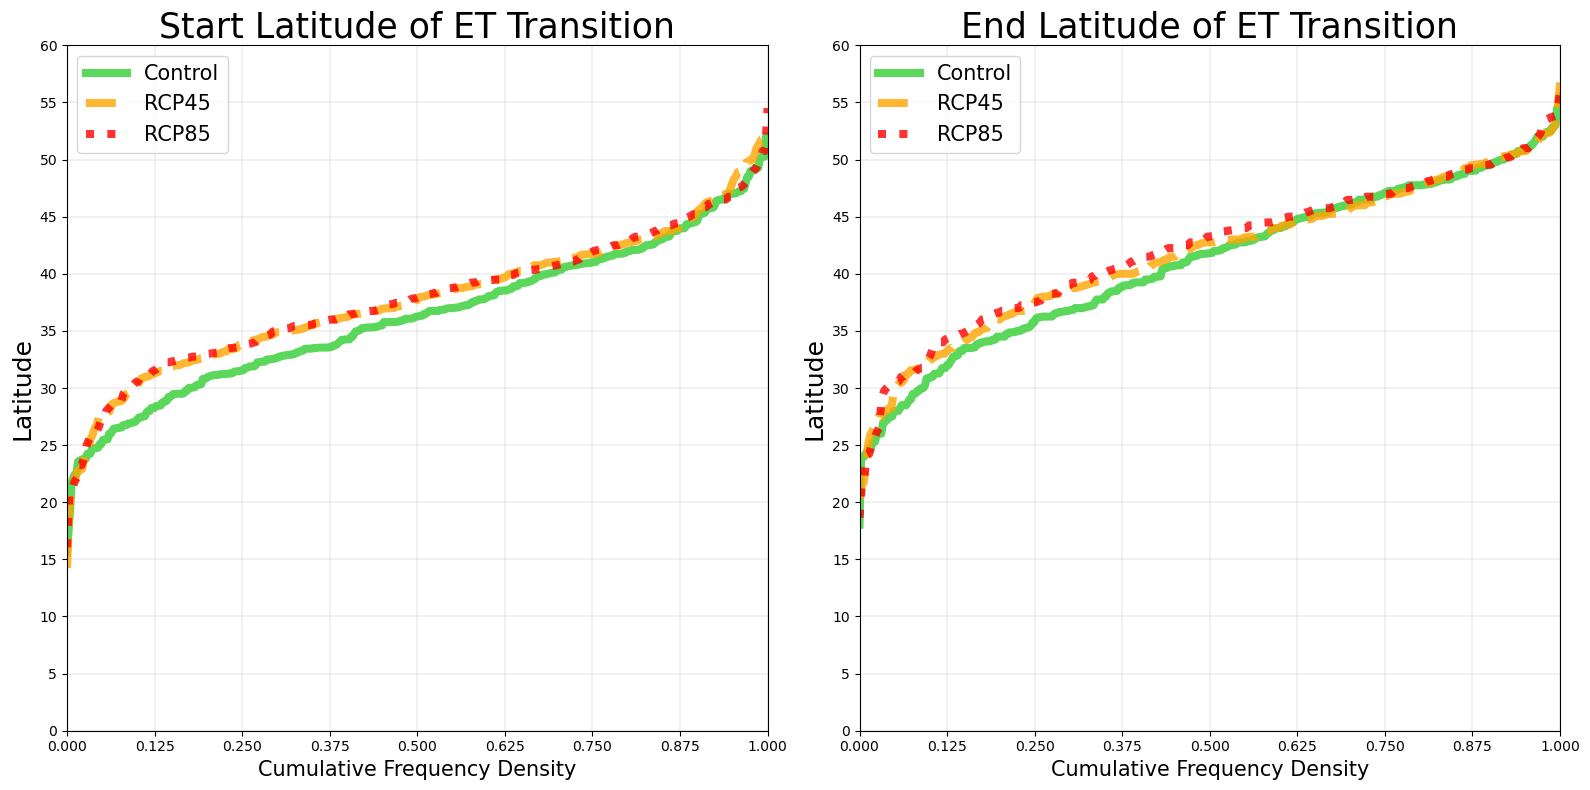

In [113]:
# Start Lat and End Lat
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lat")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lat")
pyplot.tight_layout()
Figname = str('ET_Latitude.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V2/'+Figname, bbox_inches='tight')

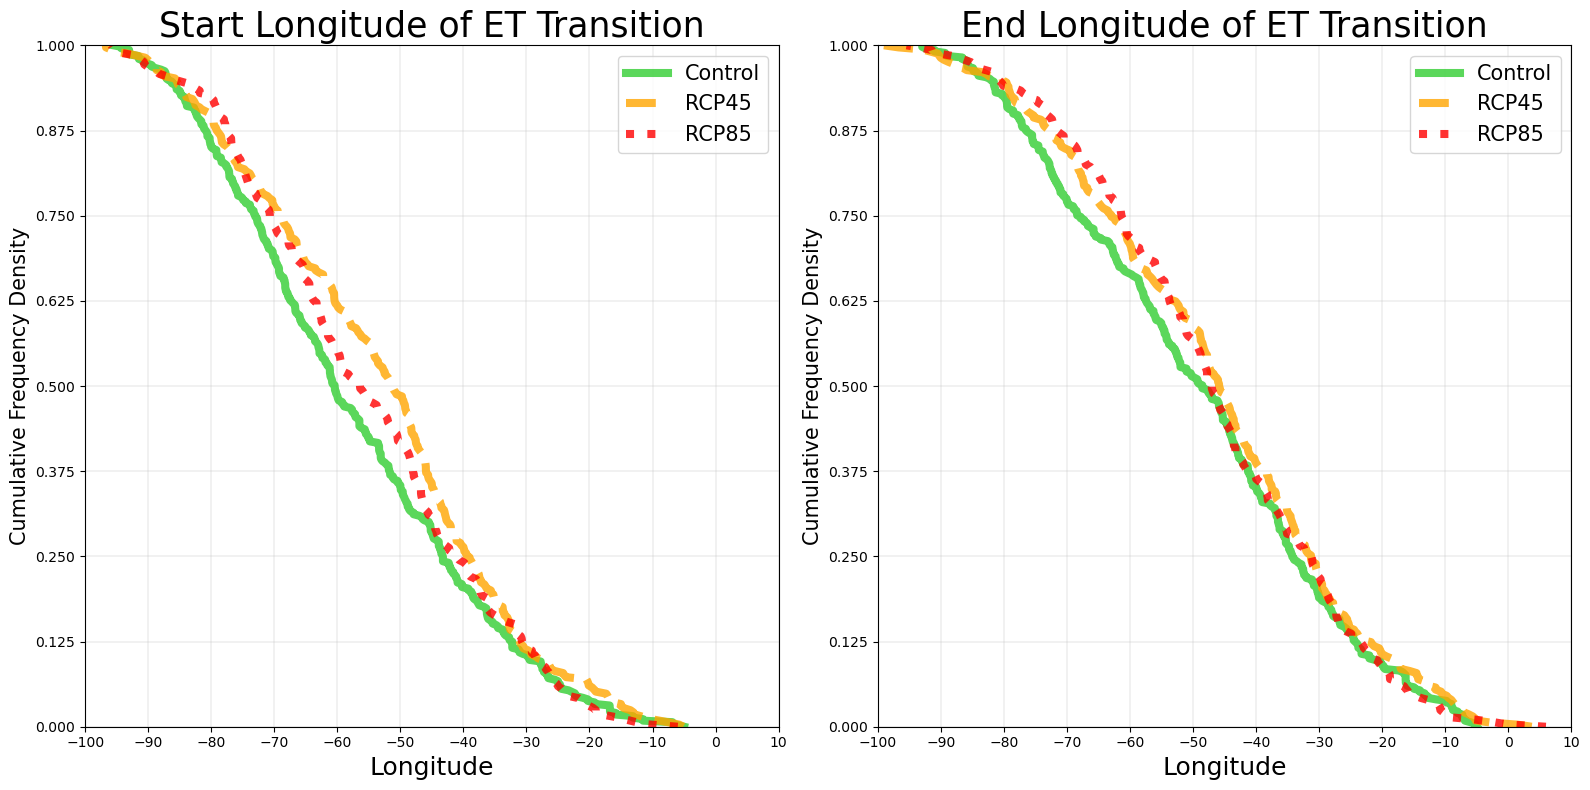

In [114]:
# Start Lon and End Lon
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lon")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lon")
pyplot.tight_layout()
Figname = str('ET_Longitude.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V2/'+Figname, bbox_inches='tight')

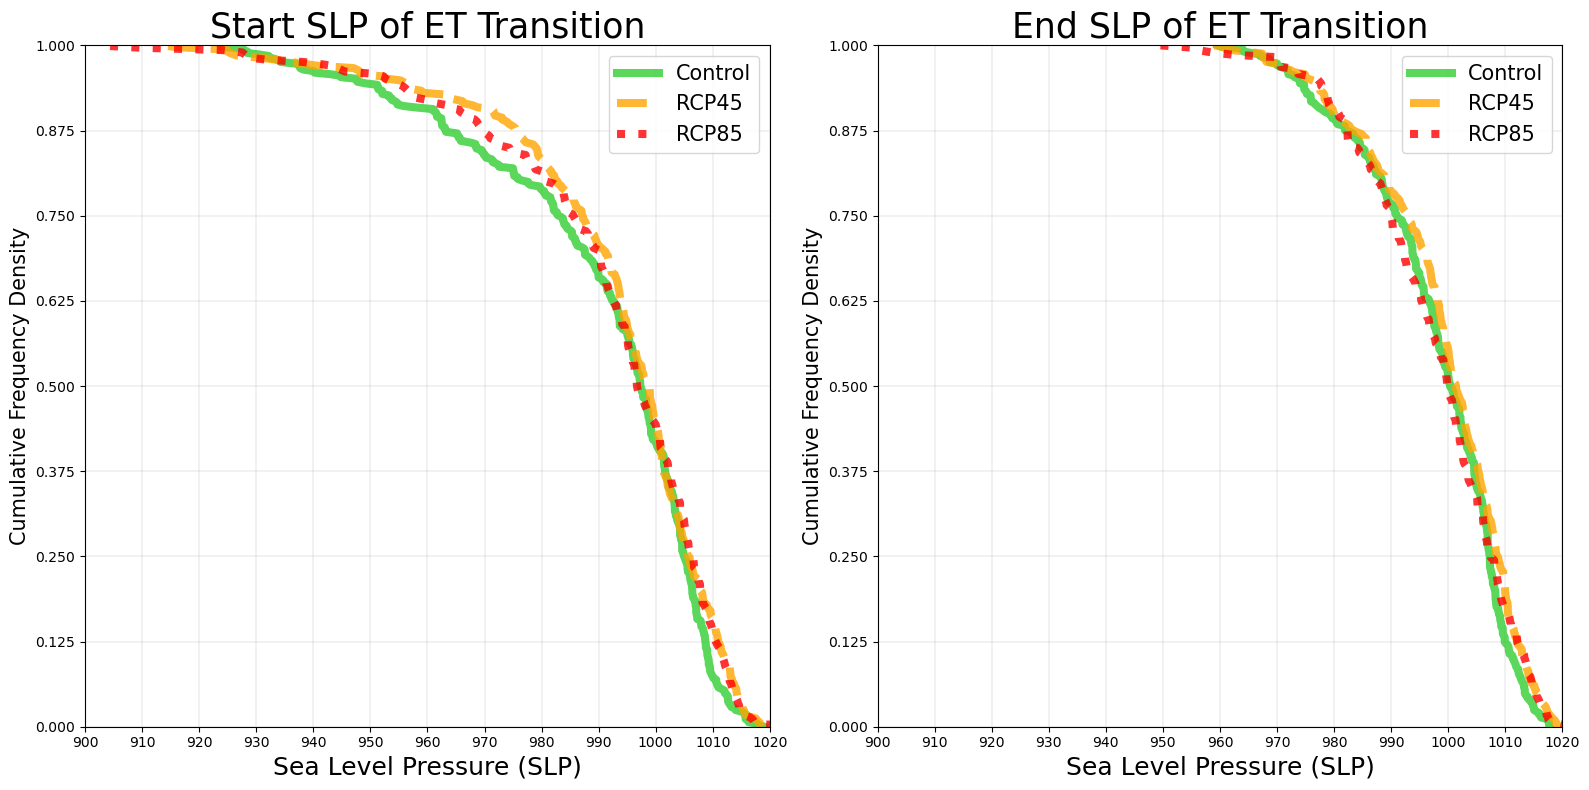

In [115]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start SLP")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End SLP")
pyplot.tight_layout()
Figname = str('ET_SLP.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V2/'+Figname, bbox_inches='tight')

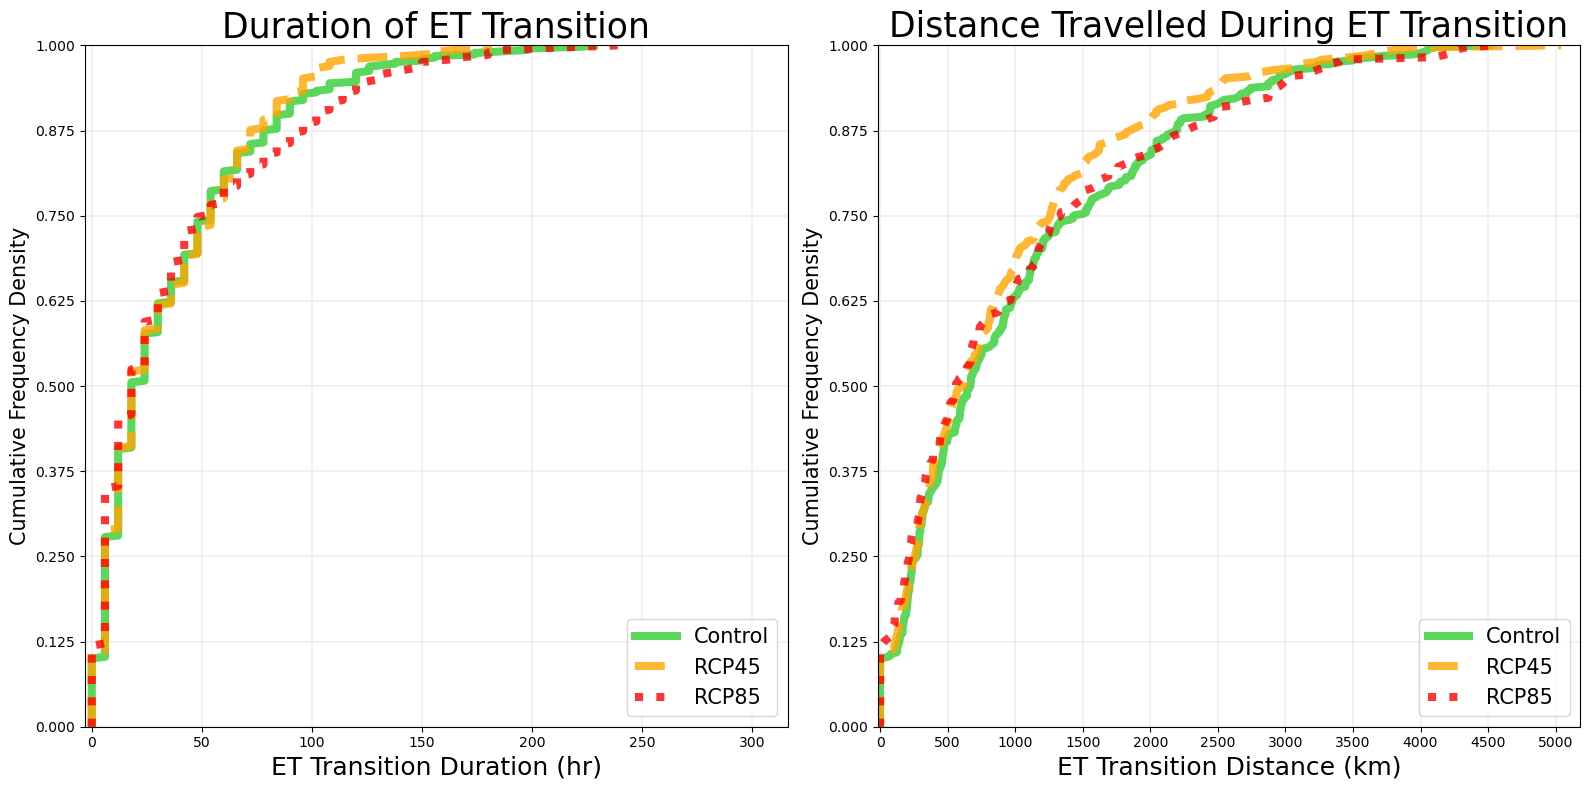

In [119]:
# ET Duration and ET Distance
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Duration (hr)")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Distance (km)")
pyplot.tight_layout()
Figname = str('ET_Duration_Distance.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V2/'+Figname, bbox_inches='tight')

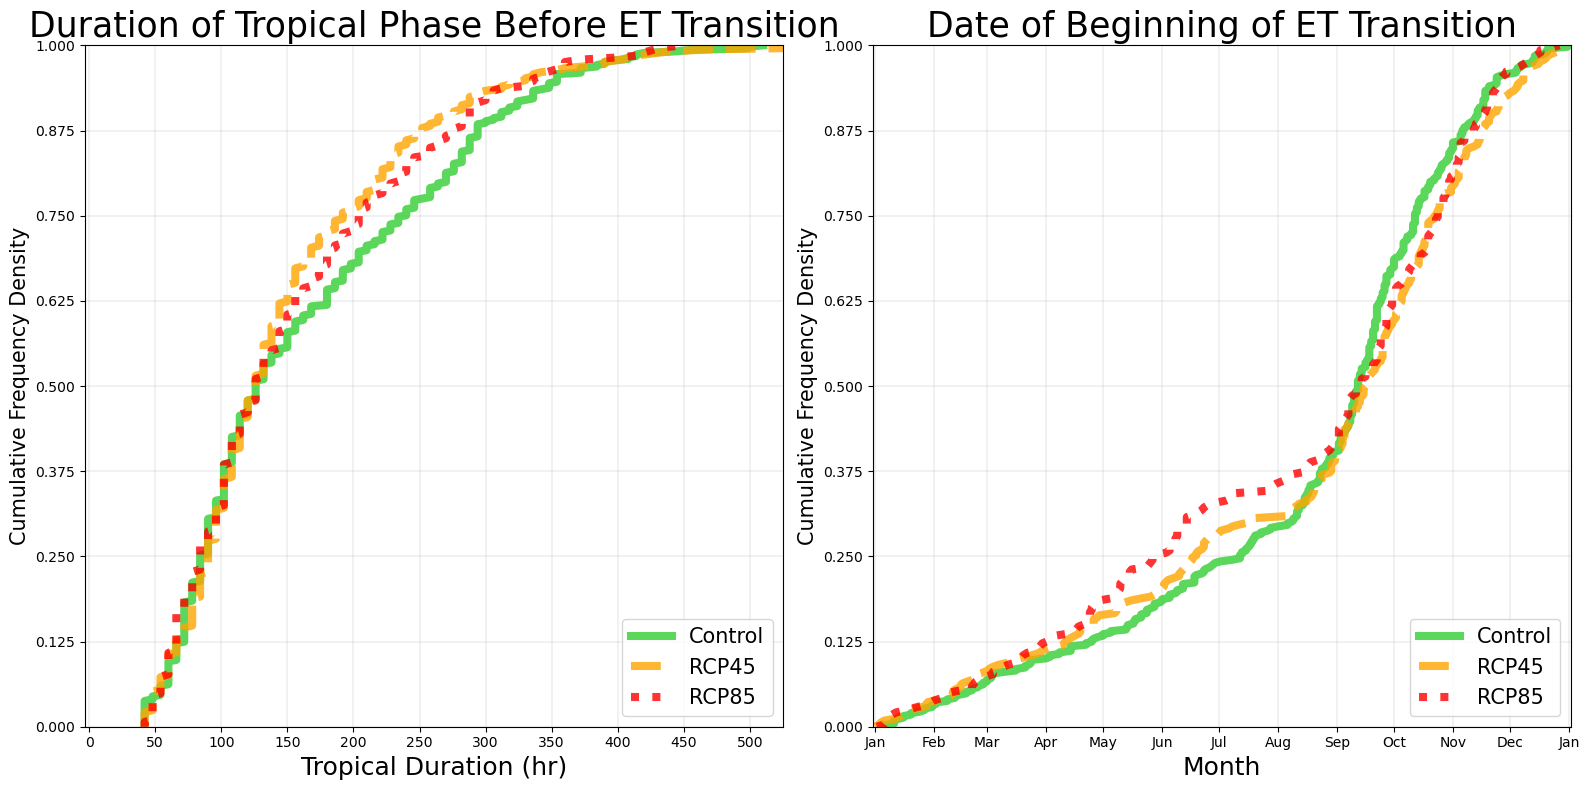

In [120]:
# ET Duration and ET Distance
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Tropical Duration (hr)")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Time")
pyplot.tight_layout()
Figname = str('ET_Month.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V2/'+Figname, bbox_inches='tight')